In [1]:
# Uncomment and run the lines below if you don't have one of the necessary packages.
# !pip install numpy
# !pip install pandas
# !pip install pingouin
# !pip install matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install scikit-learn
# !pip install factor_analyzer

In [ ]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.dpi'] = 80

In [4]:
def margin_of_error_mean(data, popsize=None, ci=.95):
    '''
    Calculate the margin of error for the mean of n values.
    
    Parameters
    ----------
    data : 1D iterable
        Values for which to perform the calculation.
    popsize : None or int, optional
        Population size (if known). Used to adjust the standard deviation.
    ci : float, optional
        Confidence interval.
    
    Returns
    -------
    me : float
        Margin of error.
    
    References
    ----------
    .. [1] https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Confidence_Intervals_for_One_Mean_with_Tolerance_Probability.pdf
    '''
    n = len(data)
    s = np.std(data)
    t = stats.t.ppf((1+ci)/2, n-1)
    if popsize is not None:
        s = s*np.sqrt(1-n/popsize)
    me = t*s/np.sqrt(n)
    
    return me

def two_proportions_z_test(x0, n0, x1, n1, null=0):
    '''
    Calculates the Z statistic for two proportions.

    Parameters
    ----------
    x0 : int
        Number of successes for the first group.
    n0 : int
        Number of trials for the first group.
    x1 : int
        Number of successes for the second group.
    n1 : int
        Number of trials for the second group.
    null : float, optional
        The value of the null.
        By default it's assumed to be 0 (The proportions should be equal).

    Returns
    -------
    z : float
        The Z statistic.

    References
    ----------
    .. [1] https://www.statisticshowto.com/z-test/
    '''
    p0, p1 = x0/n0, x1/n1
    p = (x0+x1)/(n0+n1)
    z = ((p1-p0)-null)/np.sqrt(p*(1-p)/n0 + p*(1-p)/n1)
    return z

def parallel_analysis(data, percentile=95, iterations=50, plot=False):
    '''
    Perform parallel analysis to determine the number of factors to retain for factor analysis.
    Uses sklearn's PCA. Uses Matplotlib if plot=True.
    
    Parameters
    ----------
    data : 1D iterable
        Data for which to perform analysis.
    percentile : float, optional
        Value for which to apply the percentile criterion. Should be between 0 and 100.
    iterations : int, optional
        Number of times to calculate eigenvalues for random data.
    plot : boolean, optional
        If True, returns an Matplotlib plot with the calculated eigenvalues.
        If False, returns simply the number of factors to retain.
    
    Returns
    -------
    factors : [int, int] (if plot == False)
        The estimated number of factors to retain.
        First value is based on the mean criterion, second is based on the percentile criterion.
    fig, ax : Matplotlib Figure, Matplotlib Axes (if plot == True)
        Plot with calculated eigenvalues for real and random data.
    
    References
    ----------
    .. [1] https://journals.sagepub.com/doi/pdf/10.1177/1094428104263675
    .. [2] https://journals.sagepub.com/doi/pdf/10.1177/1536867X0900900207
    '''
    pca = PCA()
    eigen_data = pca.fit(data/np.std(data)).explained_variance_ # Eigenvalues for real data.
    
    eigen_rand = [] # Will be used to store the eigenvalues for random data.
    for i in range(iterations):
        x = np.random.normal(size=np.shape(data))
        eigen_rand.append(pca.fit(x).explained_variance_)
    eigen_mean = np.mean(eigen_rand, axis=0) # Eigenvalues considering mean criterion.
    eigen_perc = np.percentile(eigen_rand, percentile, axis=0) # Eigenvalues considering percentile criterion.
    
    if plot:
        fig, ax = plt.subplots(figsize=(np.shape(data)[1]**(1/1.4), np.shape(data)[1]**(1/1.8)))
        ax.plot(eigen_data, '^-', color='black', linewidth=.9)
        ax.plot(eigen_mean, 's--', color='black', linewidth=.9, fillstyle='none')
        ax.plot(eigen_perc, 'x-.', color='black', linewidth=.9)
        ax.set_xticks(range(np.shape(data)[1]))
        ax.set_xticklabels(range(1, np.shape(data)[1]+1) if np.shape(data)[1] <= 20 else
                           [i if i%2 else '' for i in range(1, np.shape(data)[1]+1)])
        ax.set_xlim((-1, np.shape(data)[1]))
        ax.set_yticks(range(0, int(eigen_data.max())+3))
        ax.set_ylim((0, int(eigen_data.max())+2))
        ax.set_xlabel('Factor', fontsize=13)
        ax.set_ylabel('Eigenvalue', fontsize=13)
        ax.legend(['Real data', 'PA Mean', 'PA {}th percentile'.format(percentile)])
        ax.grid(axis='y', linestyle='--')
        return fig, ax
    else:
        factors = [np.sum(eigen_data > eigen_mean), np.sum(eigen_data > eigen_perc)]
        return factors

# Adds newline character every 'size' characters to make the string more readable in plots.
parse_string = lambda s, size: reduce(lambda x, y: x + (' ' if len(x.split('\n')[-1]+y) < size else '\n') + y, s.split(' '))

In [5]:
# Some of the answers need to be parsed.
frequencies = dict(zip(['Never', 'Less than once a week', '1 - 2 days/week', '3 - 4 days/week', '5 - 7 days/week'], range(5)))
friends = dict(zip([str(i) for i in range(20)]+['20+'], range(21)))
convention = dict(zip(["No, and I'm not interested in going to one", "No, but I'd like to go to one in the future", "Yes"], range(3)))
fursuit = dict(zip(["No, and I'm not interested in getting one", "No, but I'd like to get one the future", "Yes"], range(3)))
fursona = dict(zip(["No, and I'm not interested in getting one", "No, but I'd like to get one the future", "Yes"], range(3)))

In [6]:
# For question 5:
# 1 - Having an interest in anthropomorphic beings (to varying degrees)
# 2 - Liking to draw pictures of animals
# 3 - To have/want/like fursuits
# 4 - Liking to roleplay as an anthro/animal
# 5 - Describing oneself as a furry or as part of the furry fandom
# 6 - Having/wanting a fursona
# 7 - Identifying as or with an animal or anthro
# 8 - Having a sexual attraction to anthros, fursuits, or people who identify as animals
# 9 - Zoophilia
# 10 - Liking things with fur
# 11 - A form of escapism
# DK - Don't know
# NA - No answer/Prefer not to answer
# ? - Vague/Uncategorizable answer

In [7]:
# Code below was used to parse some of the questions and save the to "Opinions on furries and furry content PREPROCESSED.csv".

# df = pd.read_csv('C:/Users/Ragdoll/Documents/Surveys/Opinions on furries/Opinions on furries and furry content.csv')

# # Index all keys to make them easier to locate.
# df.columns = ['({}) {}'.format(i, k) for i,k in enumerate(df.keys())]

# # Some of the answers need to be parsed.
# frequencies = dict(zip(['Never', 'Less than once a week', '1 - 2 days/week', '3 - 4 days/week', '5 - 7 days/week'], range(5)))
# friends = dict(zip([str(i) for i in range(20)]+['20+'], range(21)))
# convention = dict(zip(["No, and I'm not interested in going to one", "No, but I'd like to go to one in the future", "Yes"], range(3)))
# fursuit = dict(zip(["No, and I'm not interested in getting one", "No, but I'd like to get one the future", "Yes"], range(3)))
# fursona = dict(zip(["No, and I'm not interested in getting one", "No, but I'd like to get one the future", "Yes"], range(3)))
# df.iloc[:, 16] = df.iloc[:, 16].map(lambda x: int(x == 'Yes'))
# df.iloc[:, 17] = df.iloc[:, 17].map(lambda x: int(x == 'Yes'))
# for i in range(19, 30):
#     df.iloc[:, i] = df.iloc[:, i].map(frequencies)
# df.iloc[:, 30] = df.iloc[:, 30].map(friends)
# df.iloc[:, 31] = df.iloc[:, 31].map(convention)
# df.iloc[:, 32] = df.iloc[:, 32].map(fursuit)
# df.iloc[:, 33] = df.iloc[:, 33].map(fursona)

# df['Furriness'] = df.iloc[:, 6:13].sum(axis=1) # "Furriness" scale. The validity of these items will be shown later.
# df['Has account furry website'] = df.iloc[:, 18].map(lambda x: int(x != "Don't have an account on any of these websites")) # 1 if respondent has account on any furry website.
# df['Access furry once week'] = (df.iloc[:, 19:30] >= 2).any(axis=1).astype('int32') # 1 if respondent accesses furry websites/communities at least once a week.

# # Create new DataFrames for each group.
# # Only group 1 was given a definition for what a furry is, as I wanted to assess if being given a definition
# # might change how participantes answered the questions.
# df_group1 = df.loc[df.iloc[:, 0].dropna().index]
# df_group1.index = range(len(df_group1))
# df_group2 = df.loc[df.iloc[:, 1].dropna().index]
# df_group2.index = range(len(df_group2))

# df.to_csv('C:/Users/Ragdoll/Documents/Surveys/Opinions on furries/Opinions on furries and furry content PREPROCESSED.csv', index=False)
# df.head()

In [8]:
def parse_types(x):
    if x in ('NA', 'DK', '?'):
        return x
    else:
        x = x.split(',')
        return int(x[0]) if len(x) == 1 else [int(i) for i in x]

df = pd.read_csv('C:/Users/Ragdoll/Documents/Surveys/Opinions on furries/Opinions on furries and furry content PREPROCESSED.csv')

# Create new DataFrames for each group.
# Only group 1 was given a definition for what a furry is, as I wanted to assess if being given a definition
# might change how participantes answered the questions.
df_group1 = df.loc[df.iloc[:, 0].dropna().index]
df_group1.index = range(len(df_group1))
df_group2 = df.loc[df.iloc[:, 1].dropna().index]
df_group2.index = range(len(df_group2))
df_group2.iloc[:, 5] = df_group2.iloc[:, 5].fillna('NA')#.map(parse_types)

df.head()

,(0) To what extent do you think the aforementioned description of furries applies to you?,(1) Furry,(2) Scalie,(3) Brony,"(4) In your own words, how would you describe what it means to be a furry?","(5) In your own words, how would you describe what it means to be a furry? [Type]",(6) Artwork of anthropomorphic characters.,(7) Fursuits.,"(8) Furry memes, or memes about the furry fandom.","(9) Videos by furry YouTubers, or videos about the furry fandom.",...,(27) How often have you accessed the following websites/communities in the past 3 months? [Furry Discord servers],(28) How often have you accessed the following websites/communities in the past 3 months? [Furry Telegram groups],(29) How often have you accessed the following websites/communities in the past 3 months? [Furry forums],(30) How many friends do you have that are furries?,(31) Have you ever gone to a furry convention?,(32) Do you own a fursuit? (Either full or partial),(33) Do you have a fursona?,Furriness,Has account furry website,Access furry once week
0,0.0,NaN,NaN,NaN,NaN,NaN,3,0,5,4,...,0,0,0,0,0,0,0,17,0,0
1,NaN,7.0,2.0,0.0,Having at least an interest in anthro animals.,1,7,4,2,2,...,0,0,0,0,0,1,2,28,1,1
2,0.0,NaN,NaN,NaN,NaN,NaN,2,1,3,0,...,0,0,0,0,0,0,0,8,0,0
3,0.0,NaN,NaN,NaN,NaN,NaN,7,3,3,0,...,0,0,0,0,0,0,0,23,0,0
4,NaN,10.0,6.0,2.0,Enjoying comics or depictions of anthro animals,1,10,7,9,6,...,0,0,0,1,1,1,1,53,1,1


In [9]:
# Print all keys.
for k in df.keys():
    print(k)

(0) To what extent do you think the aforementioned description of furries applies to you?
(1) Furry
(2) Scalie
(3) Brony
(4) In your own words, how would you describe what it means to be a furry?
(5) In your own words, how would you describe what it means to be a furry? [Type]
(6) Artwork of anthropomorphic characters.
(7) Fursuits.
(8) Furry memes, or memes about the furry fandom.
(9) Videos by furry YouTubers, or videos about the furry fandom.
(10) Stories or fanfiction about furries or anthropomorphic beings.
(11) Games about furries or anthropomorphic beings.
(12) Socializing with furries (whether online or in person).
(13) To what degree do you consider yourself to be part of the furry fandom?
(14) Overall, would you say that your opinion of the furry fandom is positive or negative?
(15) Overall, would you say that the general public has a positive or negative opinion of the furry fandom?
(16) Do you follow any furry artists on social media?
(17) Do you follow any fursuiters on so

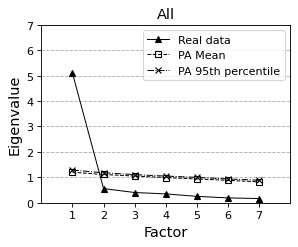

In [10]:
# Do the questions about "furry interest" all load on a single factor? (All participants)
fig, ax = parallel_analysis(df.iloc[:, 6:13], iterations=200, plot=True)
ax.set_title('All', fontsize=13)
plt.show()

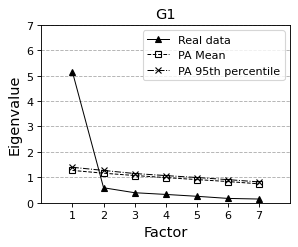

In [11]:
# Do the questions about "furry interest" all load on a single factor? (Group 1)
fig, ax = parallel_analysis(df_group1.iloc[:, 6:13], iterations=200, plot=True)
ax.set_title('G1', fontsize=13)
plt.show()

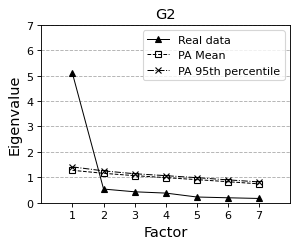

In [12]:
# Do the questions about "furry interest" all load on a single factor? (Group 2)
fig, ax = parallel_analysis(df_group2.iloc[:, 6:13], iterations=200, plot=True)
ax.set_title('G2', fontsize=13)
plt.show()

In [13]:
# Internal consistency of furriness scale.
print('Internal consistency all:', pg.cronbach_alpha(df.iloc[:, 6:13])[0].round(3))
print('Internal consistency group 1:', pg.cronbach_alpha(df_group1.iloc[:, 6:13])[0].round(3))
print('Internal consistency group 2:', pg.cronbach_alpha(df_group2.iloc[:, 6:13])[0].round(3))

Internal consistency all: 0.937
Internal consistency group 1: 0.938
Internal consistency group 2: 0.936


In [14]:
# Correlation between question 0 and furriness scale (How well description of furries applies to participant on an 11-point scale).
r = pg.corr(df_group1.iloc[:, 0], df_group1['Furriness'])['r'][0]
print('Correlation:', round(r, 3))
print('Correlation corrected for attenuation:', round(r/np.sqrt(.938), 3)) # Since one is just 1 question the internal consistency will be 1.
# Since one is just 1 question the internal consistency will be 1.

Correlation: 0.827
Correlation corrected for attenuation: 0.854


In [15]:
# Correlation between question 1 and furriness scale (Considers self furry on agree-disagree scale).
r = pg.corr(df_group2.iloc[:, 1], df_group2['Furriness'])['r'][0]
print('Correlation:', round(r, 3))
print('Correlation corrected for attenuation:', round(r/np.sqrt(.936), 3)) # Since one is just 1 question the internal consistency will be 1.

Correlation: 0.815
Correlation corrected for attenuation: 0.843


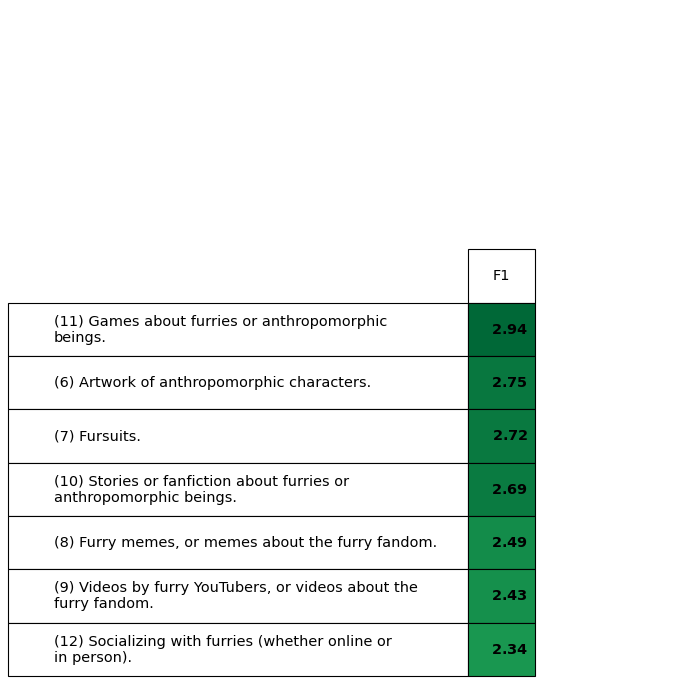

In [16]:
# Confirmatory factor analysis.
model_dict = {"F1": df.keys()[6:13]}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df.iloc[:, 6:13], model_dict)
fa = ConfirmatoryFactorAnalyzer(model_spec, disp=False)
fa.fit(df.iloc[:, 6:13].values)

# Plot loadings.
factors = 1
keys = [parse_string(k, 50) for k in df.keys()[6:13]]
loadings = pd.DataFrame(np.append(fa.loadings_, np.abs(fa.loadings_).argmax(axis=1).reshape((7, 1)), axis=1),
                        index=keys)
loadings = loadings.sort_values(factors)
loadings = loadings.loc[reduce(lambda x, y: x+y,
                               [list(loadings.iloc[np.where(loadings.iloc[:, -1] == i)].abs().sort_values(i, ascending=False).index) for i in range(factors)])]
loadings = loadings.iloc[:, :-1]


cmap = plt.get_cmap('RdYlGn')
colors = loadings.abs().max().max()
colors = cmap(np.array(loadings/(colors if colors > 1 else 1))/2+.5)

table = plt.table([[r'$\mathbf{%.2f}$' % j if (j <= -.4) | (j >= .4) else j for j in i] for i in loadings.values.round(2)],
                  colWidths=[.18]*factors,
                  colLabels=['F%i' % i for i in range(1, factors+1)],
                  rowLabels=loadings.index,
                  cellColours=colors)
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1, 4)
plt.axis('off')
plt.show()

In [17]:
def autolabel(rects, n, ax):
    for i, rect in enumerate(rects):
        width = rect.get_width()
        ax.annotate(n[i],
                    xy=(width, rect.get_y()),
                    xytext=(15, -22), textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

In [18]:
df_group2.iloc[:, 5].unique()

array(['1', '2', '3,4', '5', 'DK', 'NA', '?', '6', '4', '3,6,7', '7,8',
       '10', '7', '1,5', '1,2,3', '9', '3', '3,6', '8', '1,3', '3,7',
       '4,6', '11'], dtype=object)

30.77 4.7 4.7 3.42 2.99 2.56 2.14 2.14 8.97 2.99 21.37 13.25 

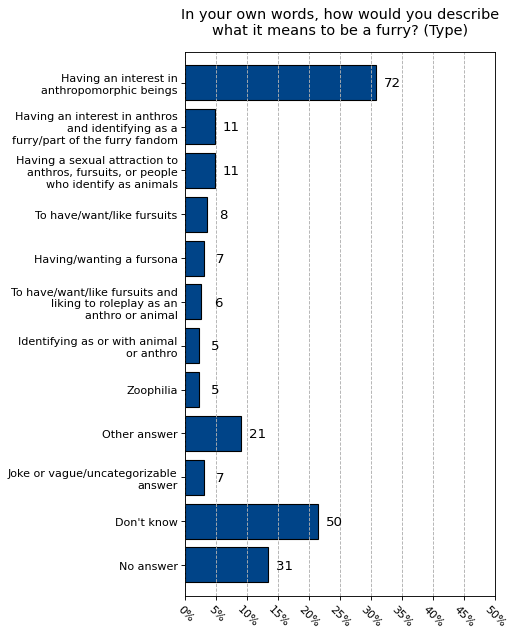

In [19]:
types = {
    'Having an interest in anthropomorphic beings' : '1',
    'Having an interest in anthros and identifying as a furry/part of the furry fandom' : '1,5',
    'Having a sexual attraction to anthros, fursuits, or people who identify as animals' : '8',
    'To have/want/like fursuits' : '3',
    'Having/wanting a fursona' : '6',
    'To have/want/like fursuits and liking to roleplay as an anthro or animal' : '3,4',
    'Identifying as or with animal or anthro' : '7',
    'Zoophilia' : '9',
    'Other answer' : ['2', '5', '4', '3,6,7', '7,8', '10', '1,2,3', '3,6', '1,3', '3,7', '4,6', '11'],
    'Joke or vague/uncategorizable answer' : '?',
    "Don't know" : 'DK',
    'No answer' : 'NA'
}

freq_types = [len(np.where(df_group2.iloc[:, 5] == x)[0]) for x in df_group2.iloc[:, 5].unique()]

fig, ax = plt.subplots(1, 1, figsize=(5, 9))

for i, k in enumerate(types):
    if k == 'Other answer':
        x = len(np.where([df_group2.iloc[j, 5] in types[k] for j in range(len(df_group2))])[0])
    else:
        x = len(np.where(df_group2.iloc[:, 5] == types[k])[0])
    rect = ax.barh(i, x, color='#048', edgecolor='black')
    autolabel(rect, [x], ax)
    print(round(100 * x / len(df_group2), 2), end=' ')
    
ax.set_ylim((-.7, 11.7))
ax.set_yticks(range(12))
ax.set_yticklabels([parse_string(k, 30) for k in types.keys()])
ax.invert_yaxis()
ax.set_xlim((0, len(df_group2)/2))
ax.set_xticks(np.arange(0, len(df_group2)/2+1, len(df_group2)/20))
ax.set_xticklabels(['{}%'.format(i) for i in range(0, 51, 5)], rotation=-45)
ax.grid(axis='x', linestyle='--')
ax.set_title(parse_string('In your own words, how would you describe what it means to be a furry? (Type)', 45), y=1.02, fontsize=13)

plt.show()

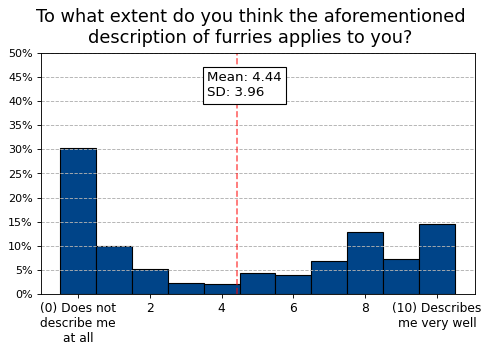

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

x = np.arange(11)
y = [len(np.where(df_group1.iloc[:, 0] == i)[0]) for i in x]
mean, std = df_group1.iloc[:, 0].mean().round(2), df_group1.iloc[:, 0].std(ddof=0).round(2)
ylim, ymax = np.sum(y)/2, 50
rects = ax.bar(x, y, color='#048', edgecolor='black', width=1)
ax.plot([mean]*2, [0, ylim], 'r--', alpha=.6)
ax.text(3.6, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
           bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
ax.set_ylim((0, ylim))
ax.set_yticks(np.arange(0, ylim+1, ylim/10))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
ax.set_xticks(range(0, 11, 2))
ax.set_xticklabels(['(0) Does not\ndescribe me\nat all']+list(range(2, 9, 2))+['(10) Describes\nme very well'], fontsize=11)
ax.grid(axis='y', linestyle='--')

fig.suptitle(parse_string('To what extent do you think the aforementioned description of furries applies to you?', 50),
             fontsize=16, y=1.02)

plt.show()

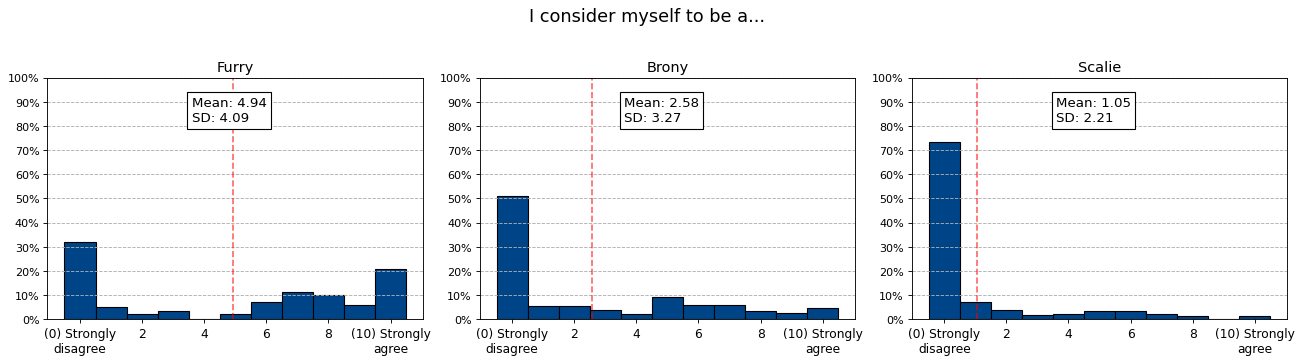

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i in range(3):
    x = np.arange(11)
    y = [len(np.where(df_group2.iloc[:, i+1] == j)[0]) for j in x]
    mean, std = df_group2.iloc[:, i+1].mean().round(2), df_group2.iloc[:, i+1].std(ddof=0).round(2)
    ylim, ymax = np.sum(y), 100
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.6, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(j) for j in range(0, ymax+1, ymax//10)])
    ax[i].set_xticks(range(0, 11, 2))
    ax[i].set_xticklabels(['(0) Strongly\ndisagree']+list(range(2, 9, 2))+['(10) Strongly\nagree'], fontsize=11)
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('Furry', 'Brony', 'Scalie')[i], fontsize=13)

fig.suptitle('I consider myself to be a...', fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

In [22]:
df_table = pd.DataFrame(index = list(df.keys()[list(range(6,16))+[30]])+['Furriness'],
                        columns = pd.MultiIndex.from_tuples([('All', 'Mean'),     ('All', 'SD'),
                                                             ('Group 1', 'Mean'), ('Group 1', 'SD'),
                                                             ('Group 2', 'Mean'), ('Group 2', 'SD'),
                                                             ('p', '')]))

for i in df_table.index:
    df_table.loc[i]['All']['Mean'] = df[i].mean().round(2)
    df_table.loc[i]['All']['SD'] = df[i].std(ddof=0).round(2)
    df_table.loc[i]['Group 1']['Mean'] = df_group1[i].mean().round(2)
    df_table.loc[i]['Group 1']['SD'] = df_group1[i].std(ddof=0).round(2)
    df_table.loc[i]['Group 2']['Mean'] = df_group2[i].mean().round(2)
    df_table.loc[i]['Group 2']['SD'] = df_group2[i].std(ddof=0).round(2)
    df_table.loc[i]['p'] = pg.ttest(df_group1[i], df_group2[i], correction=True)['p-val'][0].round(3)

df_table

All        Group 1  \
                                                     Mean     SD    Mean   
(6) Artwork of anthropomorphic characters.            6.9   3.15    6.96   
(7) Fursuits.                                        4.91   3.36     4.7   
(8) Furry memes, or memes about the furry fandom.    5.35   3.17    5.34   
(9) Videos by furry YouTubers, or videos about ...   4.26   2.99     4.2   
(10) Stories or fanfiction about furries or ant...   4.89   3.29    4.98   
(11) Games about furries or anthropomorphic bei...   5.82   3.33    5.98   
(12) Socializing with furries (whether online o...   5.31   2.98    5.26   
(13) To what degree do you consider yourself to...   3.63   3.67    3.62   
(14) Overall, would you say that your opinion o...   5.44   2.82    5.49   
(15) Overall, would you say that the general pu...   2.63   1.74    2.53   
(30) How many friends do you have that are furr...   2.45   4.91    2.44   
Furriness                                           37.45  18.98   37.43   

                                                         Group 2             p  
                                                      SD    Mean     SD         
(6) Artwork of anthropomorphic characters.          3.02    6.83   3.27  0.661  
(7) Fursuits.                                       3.23    5.15   3.48  0.146  
(8) Furry memes, or memes about the furry fandom.   3.12    5.37   3.23  0.932  
(9) Videos by furry YouTubers, or videos about ...  2.88    4.32   3.11  0.653  
(10) Stories or fanfiction about furries or ant...   3.3    4.79   3.27   0.52  
(11) Games about furries or anthropomorphic bei...  3.22    5.64   3.42  0.254  
(12) Socializing with furries (whether online o...  2.86    5.37   3.09  0.688  
(13) To what degree do you consider yourself to...  3.73    3.64    3.6  0.962  
(14) Overall, would you say that your opinion o...  2.74    5.38   2.89  0.677  
(15) Overall, would you say that the general pu...  1.67    2.73   1.81  0.212  
(30) How many friends do you have that are furr...  5.04    2.45   4.76  0.991  
Furriness                                           18.5   37.47  19.46  0.982

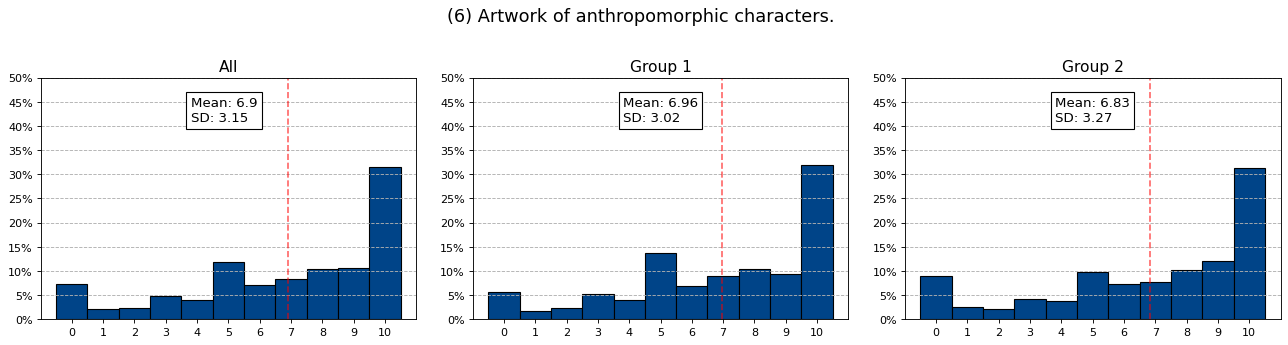

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[6]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

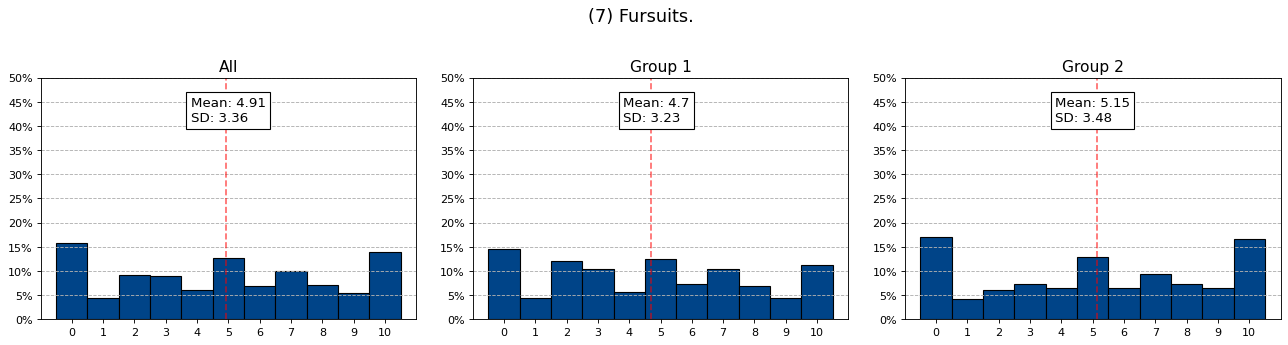

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[7]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

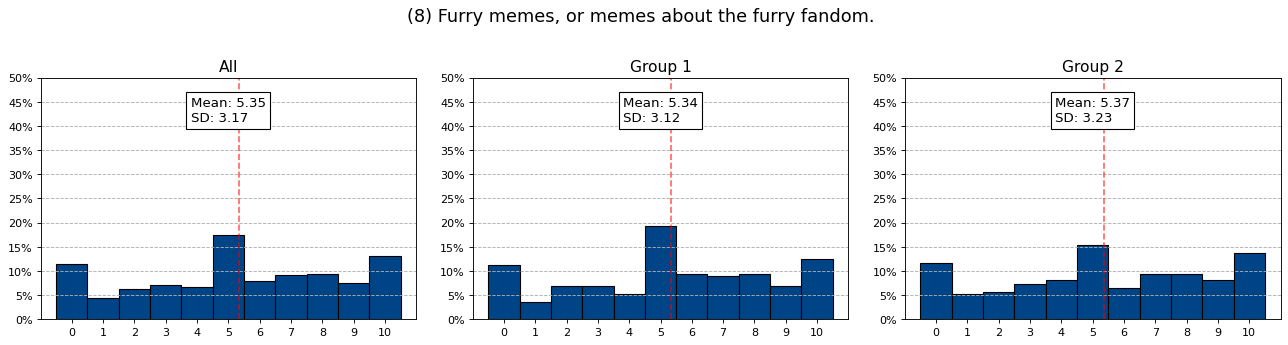

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[8]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

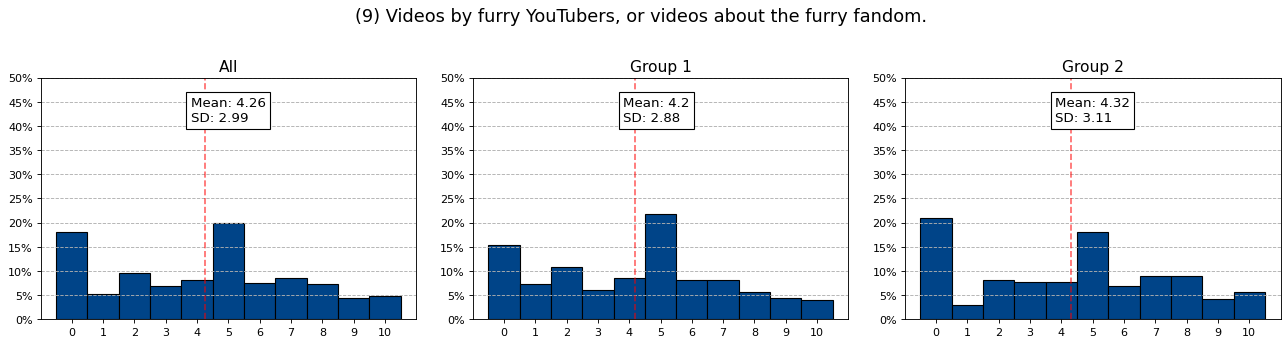

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[9]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

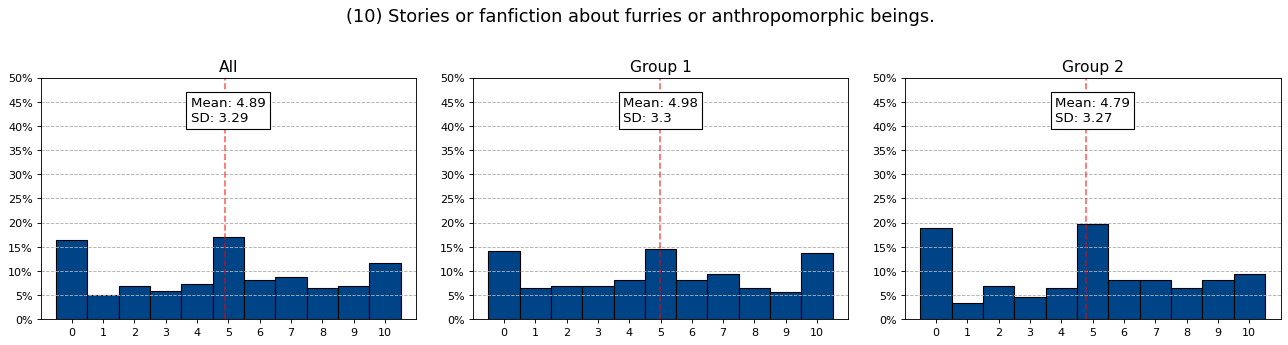

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[10]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

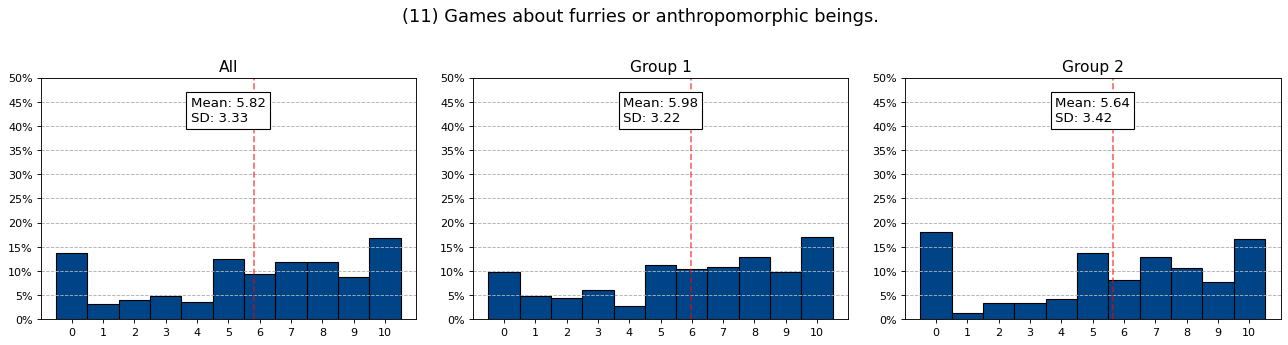

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[11]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

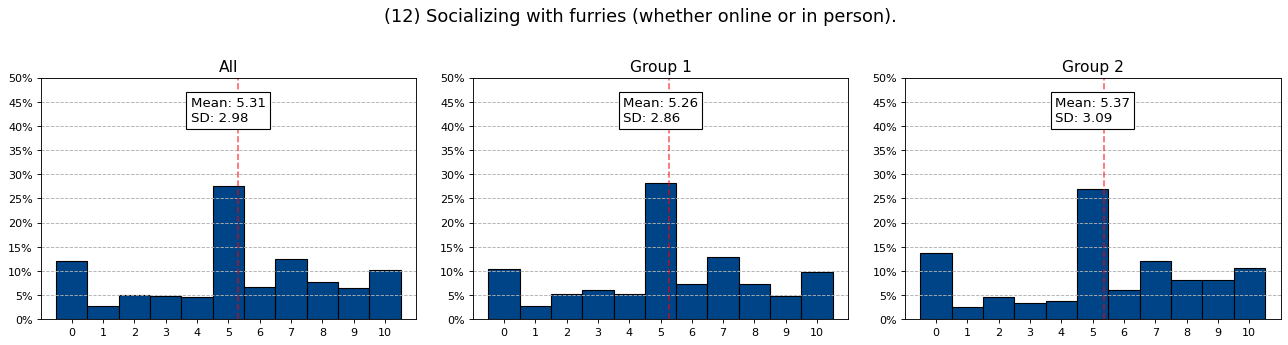

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[12]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

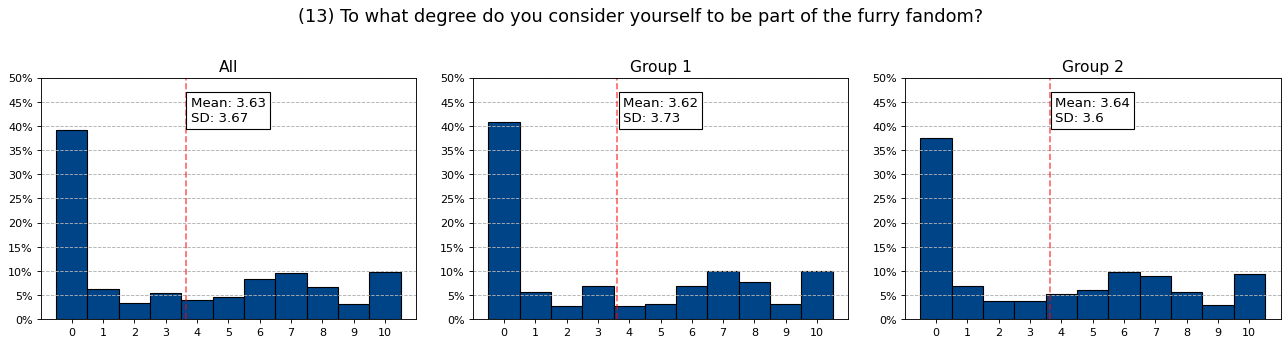

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[13]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

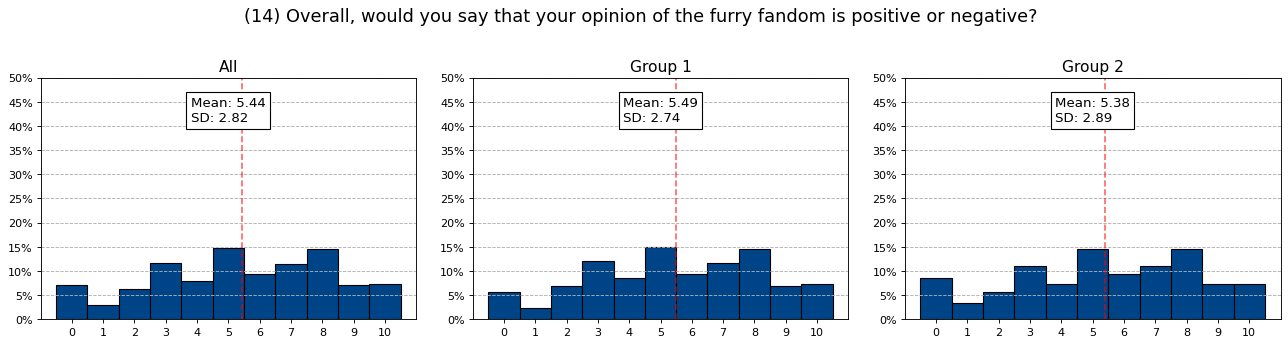

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[14]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

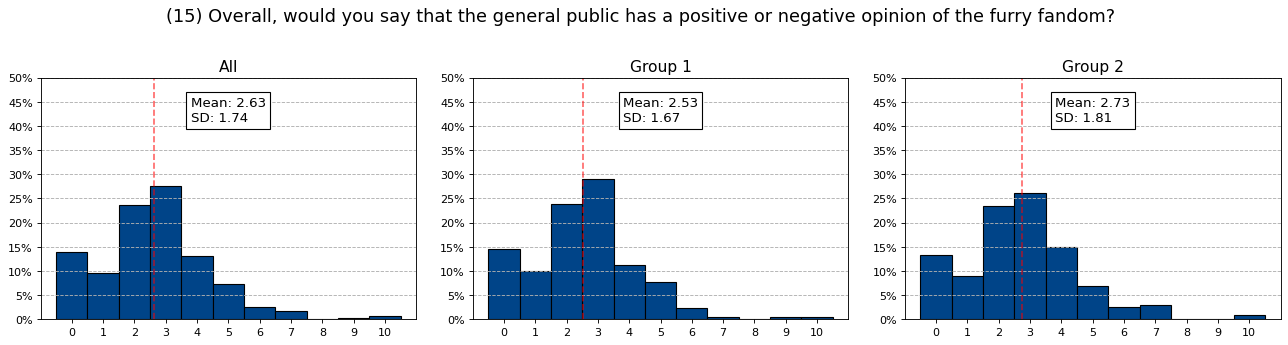

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[15]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(11)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/2, 50
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(3.8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-1, 11)
    ax[i].set_xticks(range(0, 11))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

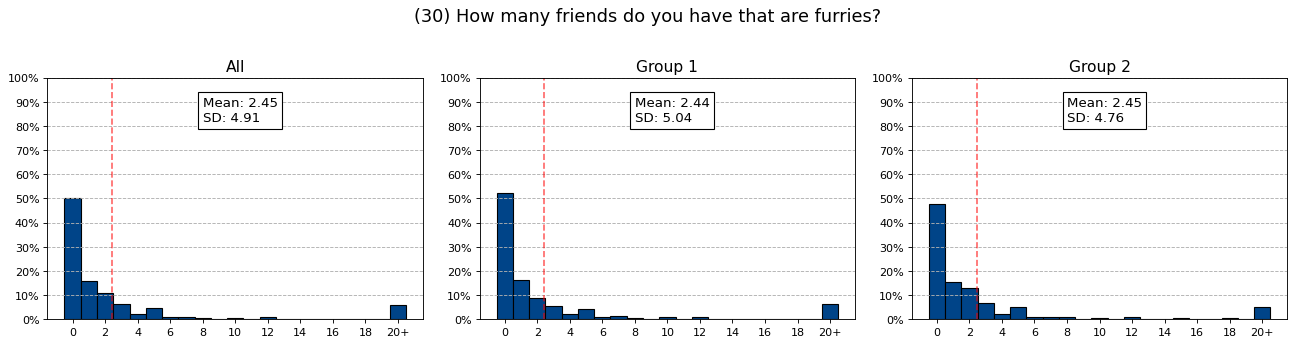

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
k = df.keys()[30]

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(21)
    y = [len(np.where(data[k] == i)[0]) for i in x]
    mean, std = data[k].mean().round(2), data[k].std(ddof=0).round(2)
    ylim, ymax = np.sum(y), 100
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(8, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xticks(range(0, 21, 2))
    ax[i].set_xticklabels(list(range(0, 20, 2))+['20+'])
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle(k, fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

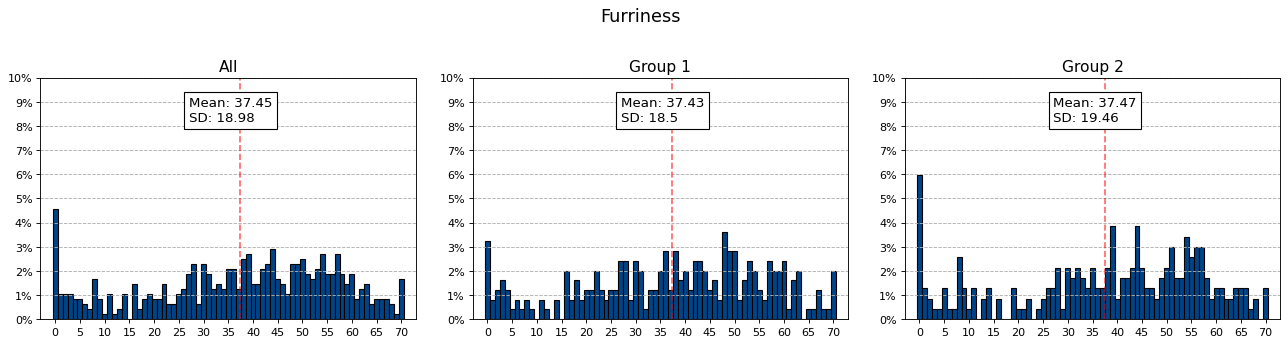

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i in range(3):
    data = (df, df_group1, df_group2)[i]
    x = np.arange(71)
    y = [len(np.where(data['Furriness'] == i)[0]) for i in x]
    mean, std = data['Furriness'].mean().round(2), data['Furriness'].std(ddof=0).round(2)
    ylim, ymax = np.sum(y)/10, 10
    rects = ax[i].bar(x, y, color='#048', edgecolor='black', width=1)
    ax[i].plot([mean]*2, [0, ylim], 'r--', alpha=.6)
    ax[i].text(27, ylim*.82, 'Mean: {}\nSD: {}'.format(mean, std),
               bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
    ax[i].set_ylim((0, ylim))
    ax[i].set_yticks(np.arange(0, ylim+1, ylim/10))
    ax[i].set_yticklabels(['{}%'.format(i) for i in range(0, ymax+1, ymax//10)])
    ax[i].set_xlim(-3, 73)
    ax[i].set_xticks(range(0, 71, 5))
    ax[i].grid(axis='y', linestyle='--')
    ax[i].set_title(('All', 'Group 1', 'Group 2')[i], fontsize=14)

fig.suptitle('Furriness', fontsize=16, y=1.1)
plt.subplots_adjust(wspace=.15)

plt.show()

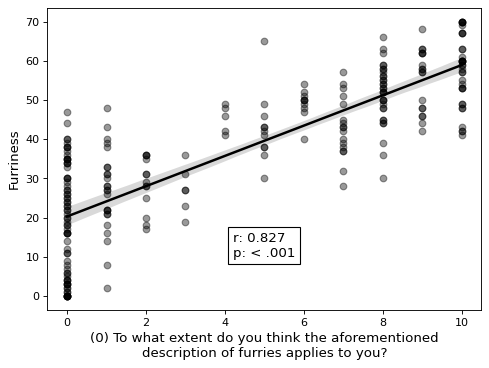

In [35]:
k = df.keys()[0]
fig = plt.figure(figsize=(7, 5))
ax = sns.regplot(df_group1[k], df_group1['Furriness'], color='black', scatter_kws={'alpha':.4})
r, p = pg.corr(df_group1[k], df_group1['Furriness'])[['r', 'p-val']].values[0].round(3)
ax.text(4.2, 10, 'r: {}\np: {}'.format(r, p if p >= .001 else '< .001'), bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
ax.set_xlim((-.5, 10.5))
ax.set_xlabel(parse_string(k, 50), fontsize=12)
ax.set_ylabel('Furriness', fontsize=12)
plt.show()

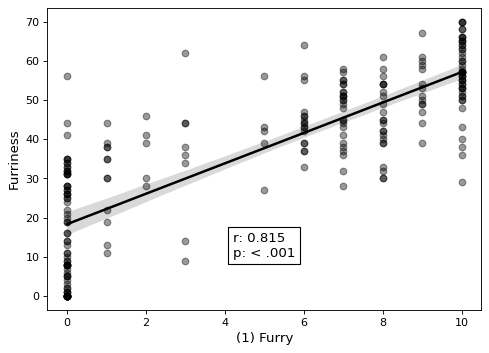

In [36]:
k = df.keys()[1]
fig = plt.figure(figsize=(7, 5))
ax = sns.regplot(df_group2[k], df_group2['Furriness'], color='black', scatter_kws={'alpha':.4})
r, p = pg.corr(df_group2[k], df_group2['Furriness'])[['r', 'p-val']].values[0].round(3)
ax.text(4.2, 10, 'r: {}\np: {}'.format(r, p if p >= .001 else '< .001'), bbox={'facecolor':'white', 'edgecolor':'black'}, fontsize=12)
ax.set_xlim((-.5, 10.5))
ax.set_xlabel(k, fontsize=12)
ax.set_ylabel('Furriness', fontsize=12)
plt.show()

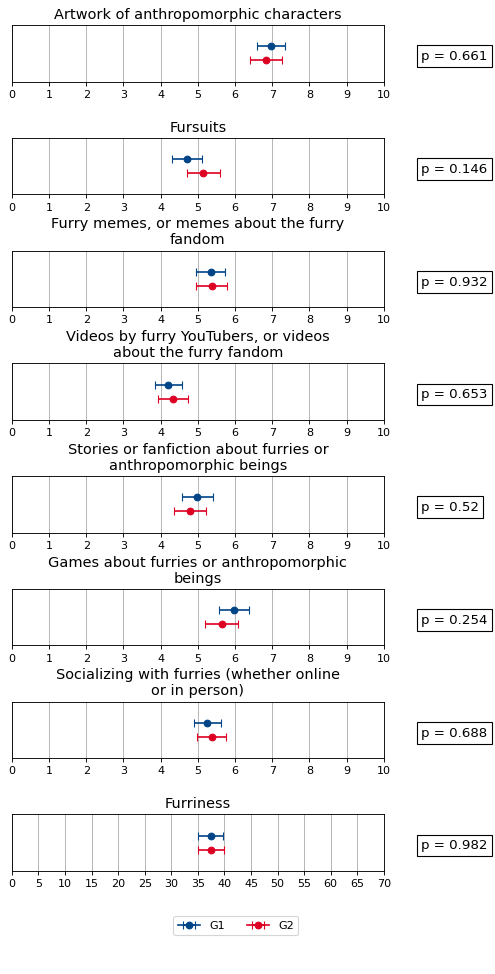

In [37]:
height = .2
ticklabels = [parse_string(s, 40) for s in ['Artwork of anthropomorphic characters', 'Fursuits', 'Furry memes, or memes about the furry fandom',
                                            'Videos by furry YouTubers, or videos about the furry fandom',
                                            'Stories or fanfiction about furries or anthropomorphic beings',
                                            'Games about furries or anthropomorphic beings', 'Socializing with furries (whether online or in person)',
                                            'Furriness']]
fig = plt.figure(figsize=(6, 14))
gs = fig.add_gridspec(len(ticklabels), 1)
ax = [fig.add_subplot(gs[i,0]) for i in range(len(ticklabels))]

for i in range(8):
    k = i+6 if i < 7 else 34
    x = df_group1.iloc[:, k].mean()
    me = margin_of_error_mean(df_group1.iloc[:, k])
    ax[i].errorbar(x, -.1, xerr=me, capsize=4, marker='o', color='#048')
    x = df_group2.iloc[:, k].mean()
    me = margin_of_error_mean(df_group2.iloc[:, k])
    ax[i].errorbar(x, .1, xerr=me, capsize=4, marker='o', color='#d02')
    ax[i].set_xlim((0, 10) if i < 7 else (0, 70))
    ax[i].set_xticks(range(0,11) if i < 7 else range(0, 71, 5))
    ax[i].set_yticks([])
    ax[i].set_ylim((-.4, .4))
    ax[i].set_title(ticklabels[i], fontsize=13)
    ax[i].grid(axis='x')
    ax[i].invert_yaxis()
    ax[i].text(11 if i < 7 else 77, .09,
               'p = {}'.format(pg.ttest(df_group1.iloc[:, k], df_group2.iloc[:, k], correction=True)['p-val'][0].round(3)),
               fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.subplots_adjust(hspace=1)
fig.legend(['G1', 'G2'], loc=(.35, .04), ncol=2)

plt.show()

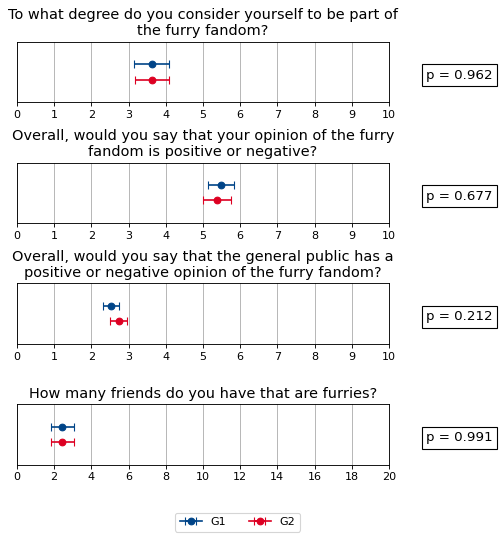

In [38]:
height = .2
ticklabels = [parse_string(s, 55) for s in ['To what degree do you consider yourself to be part of the furry fandom?',
                                            'Overall, would you say that your opinion of the furry fandom is positive or negative?',
                                            'Overall, would you say that the general public has a positive or negative opinion of the furry fandom?',
                                            'How many friends do you have that are furries?']]
fig = plt.figure(figsize=(6, 7))
gs = fig.add_gridspec(len(ticklabels), 1)
ax = [fig.add_subplot(gs[i,0]) for i in range(len(ticklabels))]

for i in range(4):
    k = [13, 14, 15, 30][i]
    x = df_group1.iloc[:, k].mean()
    me = margin_of_error_mean(df_group1.iloc[:, k])
    ax[i].errorbar(x, -.1, xerr=me, capsize=4, marker='o', color='#048')
    x = df_group2.iloc[:, k].mean()
    me = margin_of_error_mean(df_group2.iloc[:, k])
    ax[i].errorbar(x, .1, xerr=me, capsize=4, marker='o', color='#d02')
    ax[i].set_xlim((0, 10) if i < 7 else (0, 70))
    ax[i].set_xticks(range(0, 21, 2) if k == 30 else range(0, 11))
    ax[i].set_yticks([])
    ax[i].set_ylim((-.4, .4))
    ax[i].set_title(ticklabels[i], fontsize=13)
    ax[i].grid(axis='x')
    ax[i].invert_yaxis()
    ax[i].text(22 if k == 30 else 11, .09,
               'p = {}'.format(pg.ttest(df_group1.iloc[:, k], df_group2.iloc[:, k], correction=True)['p-val'][0].round(3)),
               fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.subplots_adjust(hspace=1)
fig.legend(['G1', 'G2'], loc=(.35, .01), ncol=2)

plt.show()

In [39]:
df_table = pd.DataFrame(index = ['Negative', 'Neutral', 'Positive'],
                        columns = pd.MultiIndex.from_tuples([('All', 'N'), ('All', '%'),
                                                             ('G1', 'N'),  ('G1', '%'),
                                                             ('G2', 'N'),  ('G2', '%'),
                                                             ('p', '')]))

df_table.loc['Negative']['All']['N'] = (df.iloc[:, 14] < 5).sum()
df_table.loc['Negative']['All']['%'] = ((df.iloc[:, 14] < 5).sum() / len(df)).round(3) * 100
df_table.loc['Negative']['G1']['N'] = (df_group1.iloc[:, 14] < 5).sum()
df_table.loc['Negative']['G1']['%'] = ((df_group1.iloc[:, 14] < 5).sum() / len(df_group1)).round(3) * 100
df_table.loc['Negative']['G2']['N'] = (df_group2.iloc[:, 14] < 5).sum()
df_table.loc['Negative']['G2']['%'] = ((df_group2.iloc[:, 14] < 5).sum() / len(df_group2)).round(3) * 100
p = ((1 - stats.norm(0, 1).cdf(np.abs(two_proportions_z_test((df_group1.iloc[:, 14] < 5).sum(), len(df_group1),
                                                          (df_group2.iloc[:, 14] < 5).sum(), len(df_group2))))) * 2).round(3)
df_table.loc['Negative']['p'] = p

df_table.loc['Neutral']['All']['N'] = (df.iloc[:, 14] == 5).sum()
df_table.loc['Neutral']['All']['%'] = ((df.iloc[:, 14] == 5).sum() / len(df)).round(3) * 100
df_table.loc['Neutral']['G1']['N'] = (df_group1.iloc[:, 14] == 5).sum()
df_table.loc['Neutral']['G1']['%'] = ((df_group1.iloc[:, 14] == 5).sum() / len(df_group1)).round(3) * 100
df_table.loc['Neutral']['G2']['N'] = (df_group2.iloc[:, 14] == 5).sum()
df_table.loc['Neutral']['G2']['%'] = ((df_group2.iloc[:, 14] == 5).sum() / len(df_group2)).round(3) * 100
p = ((1 - stats.norm(0, 1).cdf(np.abs(two_proportions_z_test((df_group1.iloc[:, 14] == 5).sum(), len(df_group1),
                                                          (df_group2.iloc[:, 14] == 5).sum(), len(df_group2))))) * 2).round(3)
df_table.loc['Neutral']['p'] = p

df_table.loc['Positive']['All']['N'] = (df.iloc[:, 14] > 5).sum()
df_table.loc['Positive']['All']['%'] = ((df.iloc[:, 14] > 5).sum() / len(df)).round(3) * 100
df_table.loc['Positive']['G1']['N'] = (df_group1.iloc[:, 14] > 5).sum()
df_table.loc['Positive']['G1']['%'] = ((df_group1.iloc[:, 14] > 5).sum() / len(df_group1)).round(3) * 100
df_table.loc['Positive']['G2']['N'] = (df_group2.iloc[:, 14] > 5).sum()
df_table.loc['Positive']['G2']['%'] = ((df_group2.iloc[:, 14] > 5).sum() / len(df_group2)).round(3) * 100
p = ((1 - stats.norm(0, 1).cdf(np.abs(two_proportions_z_test((df_group1.iloc[:, 14] > 5).sum(), len(df_group1),
                                                          (df_group2.iloc[:, 14] > 5).sum(), len(df_group2))))) * 2).round(3)
df_table.loc['Positive']['p'] = p

print(df.keys()[14])
df_table

(14) Overall, would you say that your opinion of the furry fandom is positive or negative?


All         G1         G2            p
            N     %    N     %    N     %       
Negative  172  35.7   88  35.5   84  35.9  0.925
Neutral    71  14.7   37  14.9   34  14.5  0.904
Positive  239  49.6  123  49.6  116  49.6  0.996

In [40]:
df_table = pd.DataFrame(index = ['Negative', 'Neutral', 'Positive'],
                        columns = pd.MultiIndex.from_tuples([('All', 'N'), ('All', '%'),
                                                             ('G1', 'N'),  ('G1', '%'),
                                                             ('G2', 'N'),  ('G2', '%'),
                                                             ('p', '')]))

df_table.loc['Negative']['All']['N'] = (df.iloc[:, 15] < 5).sum()
df_table.loc['Negative']['All']['%'] = ((df.iloc[:, 15] < 5).sum() / len(df)).round(3) * 100
df_table.loc['Negative']['G1']['N'] = (df_group1.iloc[:, 15] < 5).sum()
df_table.loc['Negative']['G1']['%'] = ((df_group1.iloc[:, 15] < 5).sum() / len(df_group1)).round(3) * 100
df_table.loc['Negative']['G2']['N'] = (df_group2.iloc[:, 15] < 5).sum()
df_table.loc['Negative']['G2']['%'] = ((df_group2.iloc[:, 15] < 5).sum() / len(df_group2)).round(3) * 100
p = ((1 - stats.norm(0, 1).cdf(np.abs(two_proportions_z_test((df_group1.iloc[:, 15] < 5).sum(), len(df_group1),
                                                          (df_group2.iloc[:, 15] < 5).sum(), len(df_group2))))) * 2).round(3)
df_table.loc['Negative']['p'] = p

df_table.loc['Neutral']['All']['N'] = (df.iloc[:, 15] == 5).sum()
df_table.loc['Neutral']['All']['%'] = ((df.iloc[:, 15] == 5).sum() / len(df)).round(3) * 100
df_table.loc['Neutral']['G1']['N'] = (df_group1.iloc[:, 15] == 5).sum()
df_table.loc['Neutral']['G1']['%'] = ((df_group1.iloc[:, 15] == 5).sum() / len(df_group1)).round(3) * 100
df_table.loc['Neutral']['G2']['N'] = (df_group2.iloc[:, 15] == 5).sum()
df_table.loc['Neutral']['G2']['%'] = ((df_group2.iloc[:, 15] == 5).sum() / len(df_group2)).round(3) * 100
p = ((1 - stats.norm(0, 1).cdf(np.abs(two_proportions_z_test((df_group1.iloc[:, 15] == 5).sum(), len(df_group1),
                                                          (df_group2.iloc[:, 15] == 5).sum(), len(df_group2))))) * 2).round(3)
df_table.loc['Neutral']['p'] = p

df_table.loc['Positive']['All']['N'] = (df.iloc[:, 15] > 5).sum()
df_table.loc['Positive']['All']['%'] = ((df.iloc[:, 15] > 5).sum() / len(df)).round(3) * 100
df_table.loc['Positive']['G1']['N'] = (df_group1.iloc[:, 15] > 5).sum()
df_table.loc['Positive']['G1']['%'] = ((df_group1.iloc[:, 15] > 5).sum() / len(df_group1)).round(3) * 100
df_table.loc['Positive']['G2']['N'] = (df_group2.iloc[:, 15] > 5).sum()
df_table.loc['Positive']['G2']['%'] = ((df_group2.iloc[:, 15] > 5).sum() / len(df_group2)).round(3) * 100
p = ((1 - stats.norm(0, 1).cdf(np.abs(two_proportions_z_test((df_group1.iloc[:, 15] > 5).sum(), len(df_group1),
                                                          (df_group2.iloc[:, 15] > 5).sum(), len(df_group2))))) * 2).round(3)
df_table.loc['Positive']['p'] = p

print(df.keys()[15])
df_table

(15) Overall, would you say that the general public has a positive or negative opinion of the furry fandom?


All         G1         G2            p
            N     %    N     %    N     %       
Negative  423  87.8  220  88.7  203  86.8  0.512
Neutral    35   7.3   19   7.7   16   6.8  0.728
Positive   24   5.0    9   3.6   15   6.4  0.161

In [41]:
df_table = pd.DataFrame(index = list(df.keys()[[16, 17, 30, 31, 32, 33, 35, 36]]),
                        columns = pd.MultiIndex.from_tuples([('All', 'N'), ('All', '%'),
                                                             ('G1', 'N'),  ('G1', '%'),
                                                             ('G2', 'N'),  ('G2', '%'),
                                                             ('p', '')]))

for i in df_table.index:
    df_table.loc[i]['All']['N'] = (df[i] >= 1).sum()
    df_table.loc[i]['All']['%'] = ((df[i] >= 1).sum() / len(df)).round(4) * 100
    df_table.loc[i]['G1']['N'] = (df_group1[i] >= 1).sum()
    df_table.loc[i]['G1']['%'] = ((df_group1[i] >= 1).sum() / len(df_group1)).round(4) * 100
    df_table.loc[i]['G2']['N'] = (df_group2[i] >= 1).sum()
    df_table.loc[i]['G2']['%'] = ((df_group2[i] >= 1).sum() / len(df_group2)).round(4) * 100
    p = ((1 - stats.norm(0, 1).cdf(np.abs(two_proportions_z_test((df_group1[i] >= 1).sum(), len(df_group1),
                                                              (df_group2[i] >= 1).sum(), len(df_group2))))) * 2).round(3)
    df_table.loc[i]['p'] = p
    
df_table

All          G1         \
                                                      N      %    N      %   
(16) Do you follow any furry artists on social ...  201   41.7   94   37.9   
(17) Do you follow any fursuiters on social media?  129  26.76   57  22.98   
(30) How many friends do you have that are furr...  240  49.79  118  47.58   
(31) Have you ever gone to a furry convention?      200  41.49   96  38.71   
(32) Do you own a fursuit? (Either full or part...  160   33.2   72  29.03   
(33) Do you have a fursona?                         253  52.49  123   49.6   
Has account furry website                           192  39.83   94   37.9   
Access furry once week                              239  49.59  121  48.79   

                                                     G2             p  
                                                      N      %         
(16) Do you follow any furry artists on social ...  107  45.73  0.082  
(17) Do you follow any fursuiters on social media?   72  30.77  0.054  
(30) How many friends do you have that are furr...  122  52.14  0.317  
(31) Have you ever gone to a furry convention?      104  44.44  0.202  
(32) Do you own a fursuit? (Either full or part...   88  37.61  0.046  
(33) Do you have a fursona?                         130  55.56   0.19  
Has account furry website                            98  41.88  0.373  
Access furry once week                              118  50.43  0.719

In [42]:
def autolabel(rects, n, ax):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(n[i],
                    xy=(rect.get_x(), height),
                    xytext=(10, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

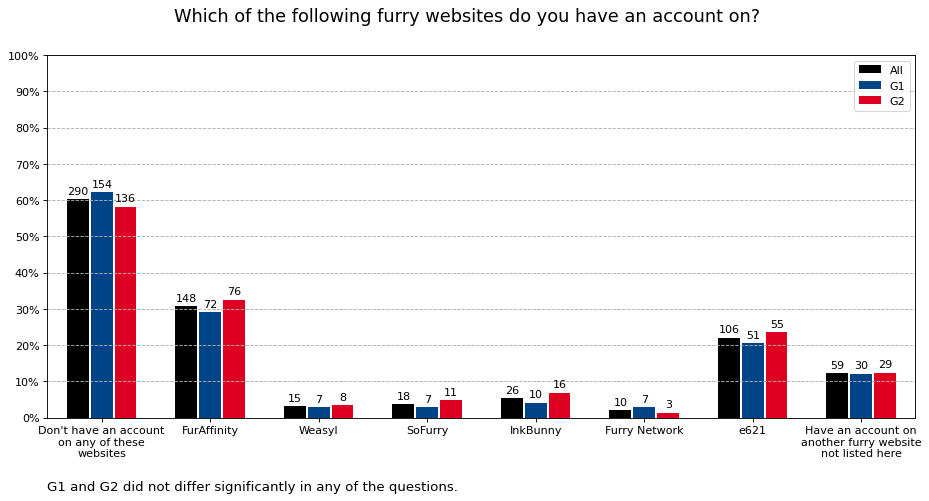

In [43]:
values = ["Don't have an account on any of these websites", 'FurAffinity', 'Weasyl', 'SoFurry', 'InkBunny',
          'Furry Network', 'e621', 'Have an account on another furry website not listed here']
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
for i in range(3):
    data = (df, df_group1, df_group2)[i].iloc[:, 18]
    y = np.zeros(8, dtype='int32')
    for j in data:
        y += [v in j for v in values]
    rects = ax.bar(np.arange(8)+.22*(i-1), y/len(data), width=.2, color=('#000', '#048', '#d02')[i])
    autolabel(rects, y, ax)

ax.set_ylim((0, 1))
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.set_xlim((-.5, 7.5))
ax.set_xticks(range(8))
ax.set_xticklabels([parse_string(s, 23) for s in values])
ax.text(-.5, -.2, 'G1 and G2 did not differ significantly in any of the questions.', fontsize=12)
ax.legend(['All', 'G1', 'G2'])
ax.grid(axis='y', linestyle='--')
fig.suptitle('Which of the following furry websites do you have an account on?', fontsize=16)
plt.show()

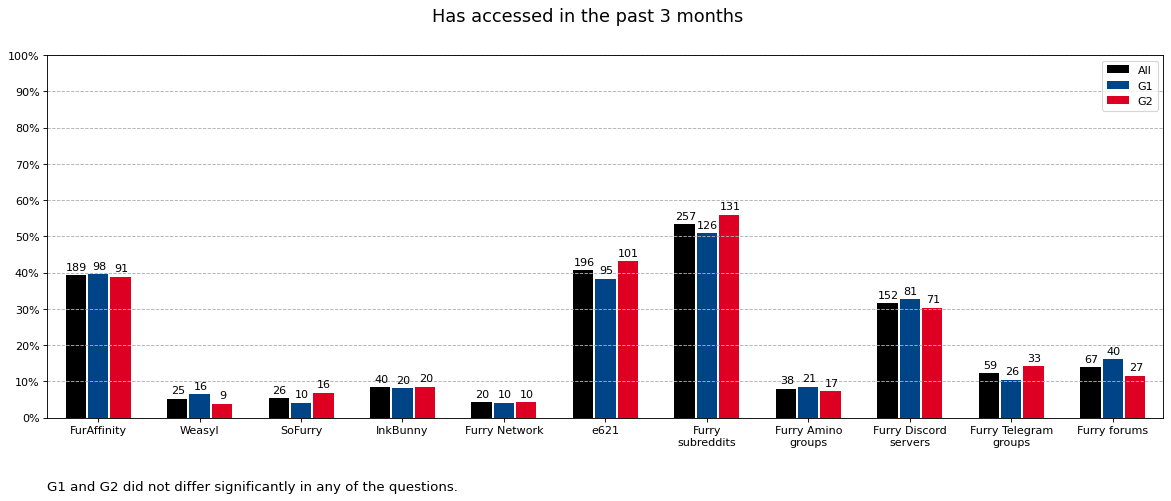

In [44]:
titles = ['FurAffinity', 'Weasyl', 'SoFurry', 'InkBunny', 'Furry Network', 'e621', 'Furry subreddits',
          'Furry Amino groups', 'Furry Discord servers', 'Furry Telegram groups', 'Furry forums']
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
for i in range(3):
    data = (df, df_group1, df_group2)[i].iloc[:, 19:30]
    y = (data >= 1).sum(axis=0).values
    rects = ax.bar(np.arange(11)+.22*(i-1), y/len(data), width=.2, color=('#000', '#048', '#d02')[i])
    autolabel(rects, y, ax)

ax.set_ylim((0, 1))
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_yticklabels(['{}%'.format(i) for i in range(0, 101, 10)])
ax.set_xlim((-.5, 10.5))
ax.set_xticks(range(11))
ax.set_xticklabels([parse_string(s, 15) for s in titles])
ax.text(-.5, -.2, 'G1 and G2 did not differ significantly in any of the questions.', fontsize=12)
ax.legend(['All', 'G1', 'G2'])
ax.grid(axis='y', linestyle='--')
fig.suptitle('Has accessed in the past 3 months', fontsize=16)
plt.show()

In [45]:
def autolabel(rects, n, ax):
    for i, rect in enumerate(rects):
        width = rect.get_width()
        ax.annotate(n[i],
                    xy=(width, rect.get_y()),
                    xytext=(15, -22), textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

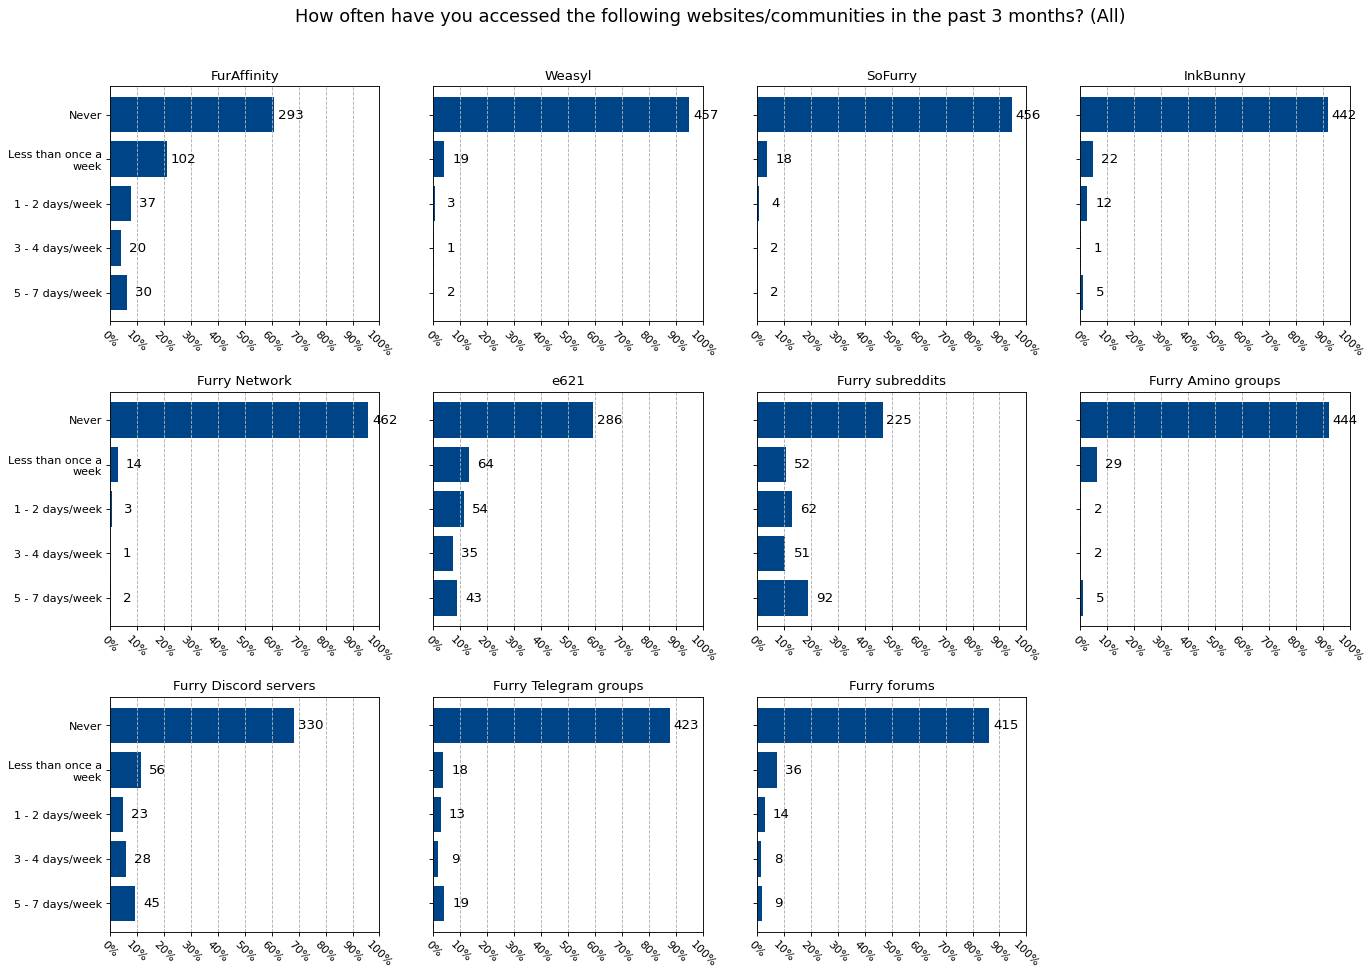

In [46]:
titles = ['FurAffinity', 'Weasyl', 'SoFurry', 'InkBunny', 'Furry Network', 'e621', 'Furry subreddits',
          'Furry Amino groups', 'Furry Discord servers', 'Furry Telegram groups', 'Furry forums']
fig, ax = plt.subplots(3, 4, figsize=(20, 14))

for i in range(3):
    for j in range(4):
        idx = i*4+j
        if idx == 11:
            break
        y, x = np.unique(df.iloc[:, 19+idx], return_counts=True)
        rects = ax[i,j].barh(y, x, color='#048')
        autolabel(rects, x, ax[i,j])
        ax[i,j].set_yticks(range(5))
        ax[i,j].set_yticklabels([parse_string(k, 20) for k in frequencies.keys()] if j == 0 else [])
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlim((0, len(df)))
        ax[i,j].set_xticks(np.arange(0, len(df)+1, len(df)/10))
        ax[i,j].set_xticklabels(['{}%'.format(i) for i in range(0, 101, 10)], rotation=-45)
        ax[i,j].grid(axis='x', linestyle='--')
        ax[i,j].set_title(titles[idx])
ax[-1,-1].axis(False)

plt.subplots_adjust(hspace=.3)
fig.suptitle('How often have you accessed the following websites/communities in the past 3 months? (All)', fontsize=16, y=.95)
plt.show()

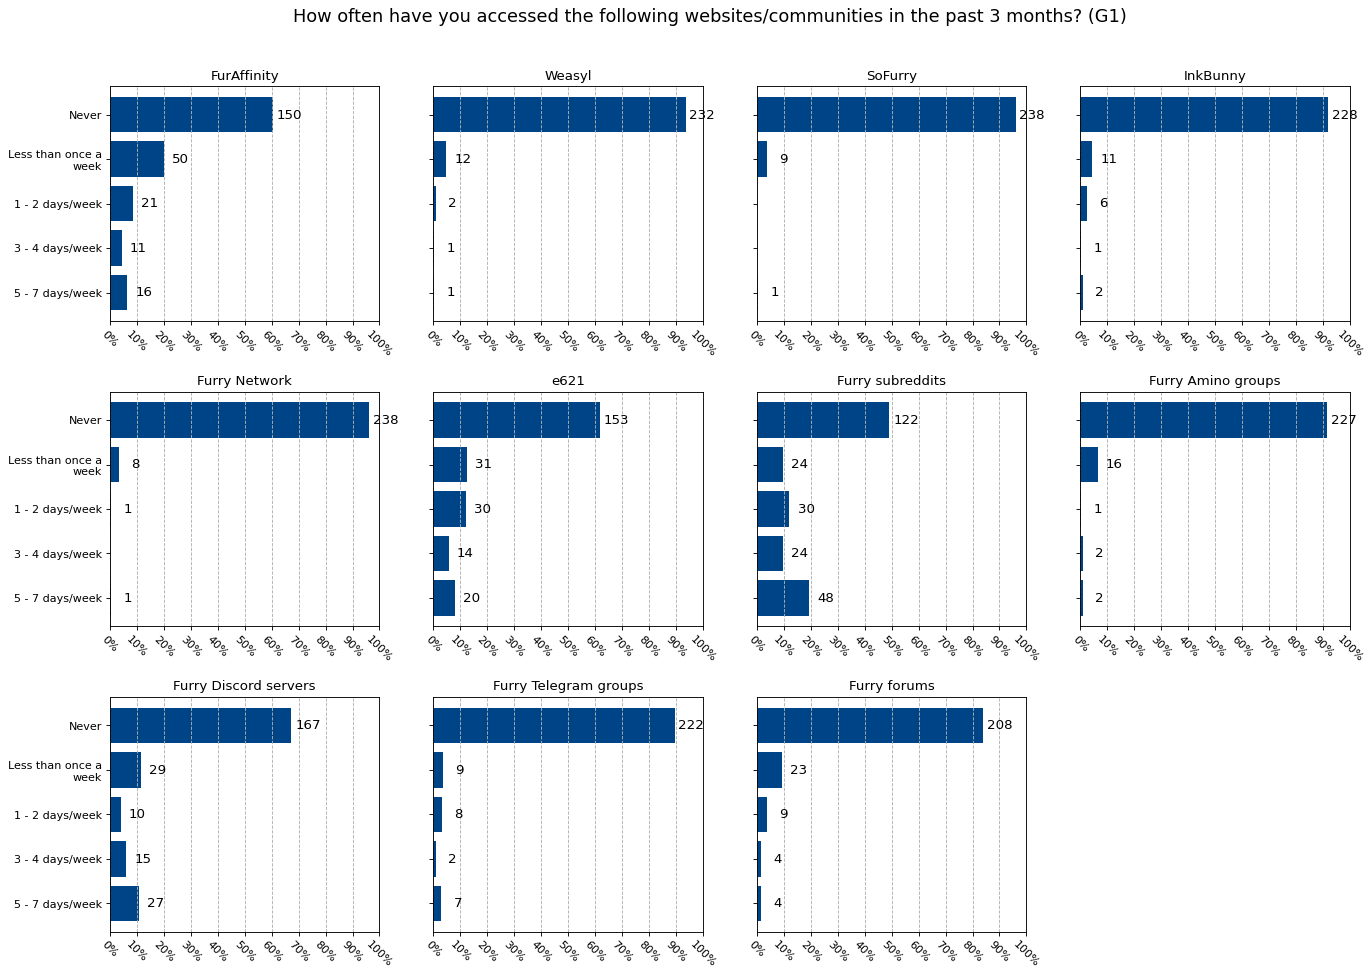

In [47]:
titles = ['FurAffinity', 'Weasyl', 'SoFurry', 'InkBunny', 'Furry Network', 'e621', 'Furry subreddits',
          'Furry Amino groups', 'Furry Discord servers', 'Furry Telegram groups', 'Furry forums']
fig, ax = plt.subplots(3, 4, figsize=(20, 14))

for i in range(3):
    for j in range(4):
        idx = i*4+j
        if idx == 11:
            break
        y, x = np.unique(df_group1.iloc[:, 19+idx], return_counts=True)
        rects = ax[i,j].barh(y, x, color='#048')
        autolabel(rects, x, ax[i,j])
        ax[i,j].set_yticks(range(5))
        ax[i,j].set_yticklabels([parse_string(k, 20) for k in frequencies.keys()] if j == 0 else [])
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlim((0, len(df_group1)))
        ax[i,j].set_xticks(np.arange(0, len(df_group1)+1, len(df_group1)/10))
        ax[i,j].set_xticklabels(['{}%'.format(i) for i in range(0, 101, 10)], rotation=-45)
        ax[i,j].grid(axis='x', linestyle='--')
        ax[i,j].set_title(titles[idx])
ax[-1,-1].axis(False)

plt.subplots_adjust(hspace=.3)
fig.suptitle('How often have you accessed the following websites/communities in the past 3 months? (G1)', fontsize=16, y=.95)
plt.show()

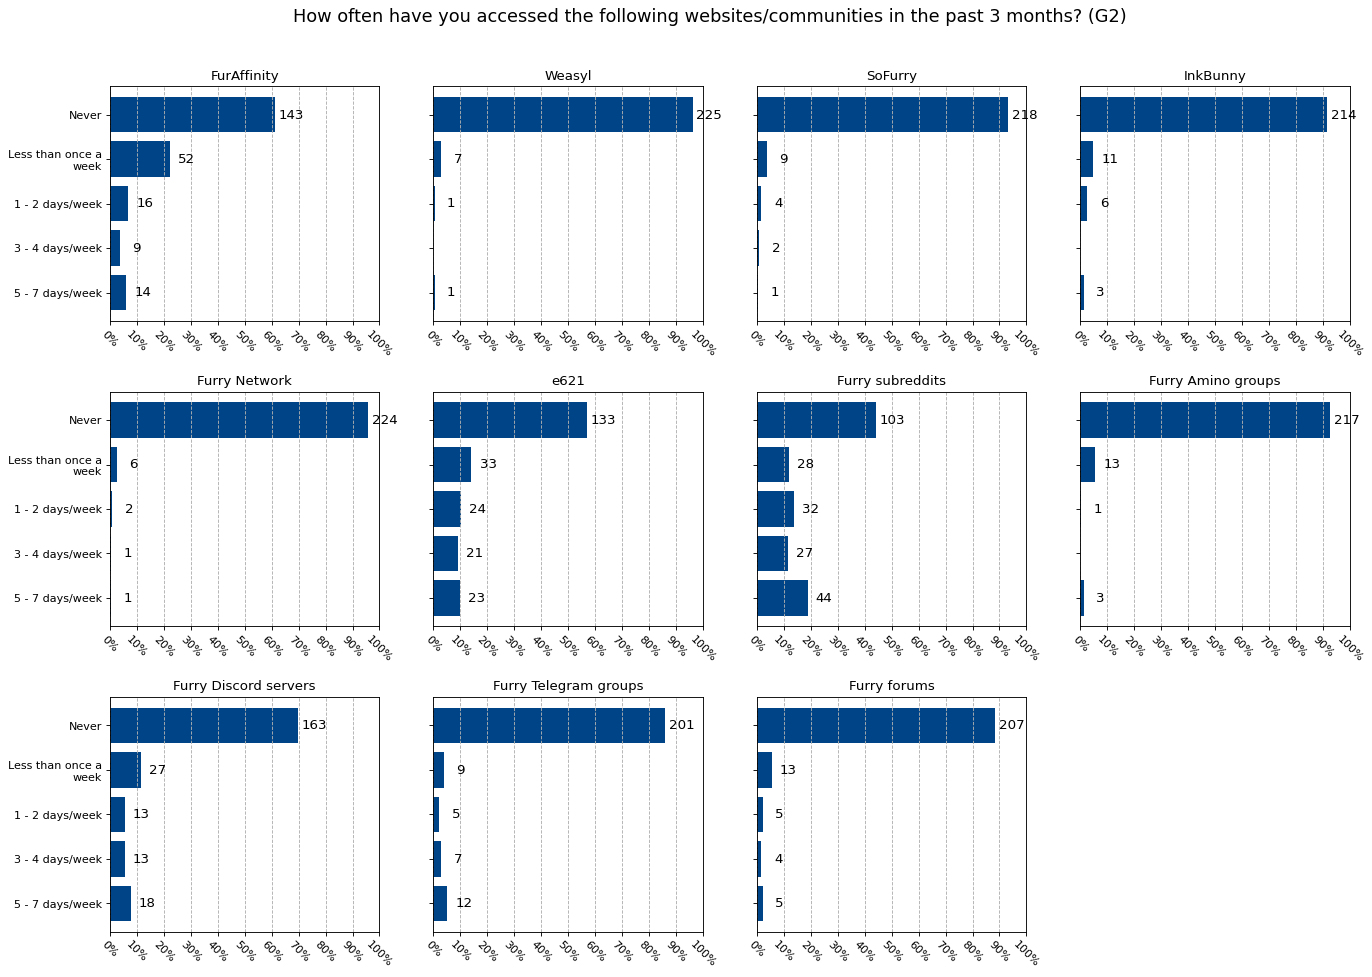

In [48]:
titles = ['FurAffinity', 'Weasyl', 'SoFurry', 'InkBunny', 'Furry Network', 'e621', 'Furry subreddits',
          'Furry Amino groups', 'Furry Discord servers', 'Furry Telegram groups', 'Furry forums']
fig, ax = plt.subplots(3, 4, figsize=(20, 14))

for i in range(3):
    for j in range(4):
        idx = i*4+j
        if idx == 11:
            break
        y, x = np.unique(df_group2.iloc[:, 19+idx], return_counts=True)
        rects = ax[i,j].barh(y, x, color='#048')
        autolabel(rects, x, ax[i,j])
        ax[i,j].set_yticks(range(5))
        ax[i,j].set_yticklabels([parse_string(k, 20) for k in frequencies.keys()] if j == 0 else [])
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlim((0, len(df_group2)))
        ax[i,j].set_xticks(np.arange(0, len(df_group2)+1, len(df_group2)/10))
        ax[i,j].set_xticklabels(['{}%'.format(i) for i in range(0, 101, 10)], rotation=-45)
        ax[i,j].grid(axis='x', linestyle='--')
        ax[i,j].set_title(titles[idx])
ax[-1,-1].axis(False)

plt.subplots_adjust(hspace=.3)
fig.suptitle('How often have you accessed the following websites/communities in the past 3 months? (G2)', fontsize=16, y=.95)
plt.show()

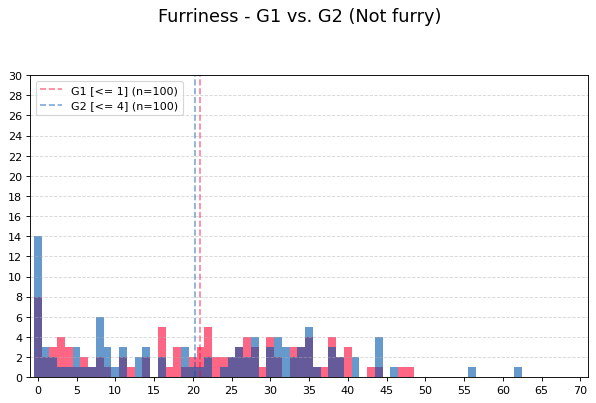

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = (df_group2.loc[np.where(df_group2.iloc[:, 1] <= 4)] if i else df_group1.loc[np.where(df_group1.iloc[:, 0] <= 1)])['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('G1 [<= 1] (n={})'.format(n0), 'G2 [<= 4] (n={})'.format(n1)), loc='upper left')

fig.suptitle('Furriness - G1 vs. G2 (Not furry)', fontsize=16, y=1.05)

plt.show()

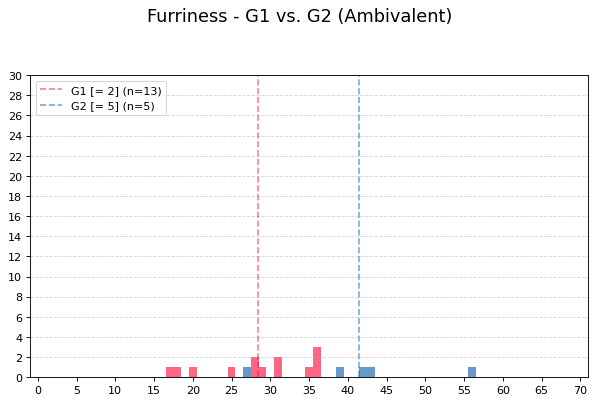

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = (df_group2.loc[np.where(df_group2.iloc[:, 1] == 5)] if i else df_group1.loc[np.where(df_group1.iloc[:, 0] == 2)])['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('G1 [= 2] (n={})'.format(n0), 'G2 [= 5] (n={})'.format(n1)), loc='upper left')
fig.suptitle('Furriness - G1 vs. G2 (Ambivalent)', fontsize=16, y=1.05)

plt.show()

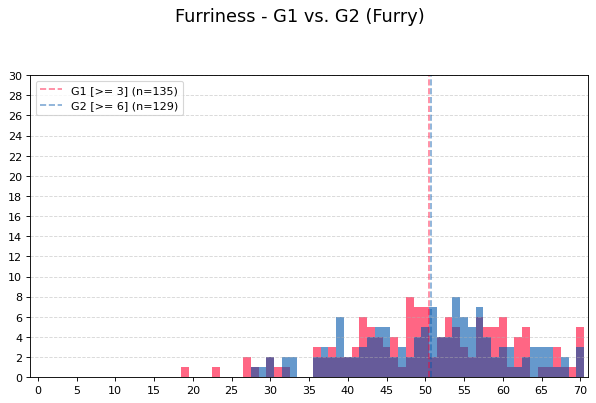

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = (df_group2.loc[np.where(df_group2.iloc[:, 1] >= 6)] if i else df_group1.loc[np.where(df_group1.iloc[:, 0] >= 3)])['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('G1 [>= 3] (n={})'.format(n0), 'G2 [>= 6] (n={})'.format(n1)), loc='upper left')
fig.suptitle('Furriness - G1 vs. G2 (Furry)', fontsize=16, y=1.05)

plt.show()

In [52]:
# Not furry
pg.ttest(df_group2[df_group2.iloc[:, 1] <= 4]['Furriness'], df_group1[df_group1.iloc[:, 0] <= 1]['Furriness'], correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.361716,194.740221,two-sided,0.717956,"[-4.77, 3.29]",0.051154,0.164,0.064972


In [53]:
# Unsure/Ambivalent
pg.ttest(df_group2[df_group2.iloc[:, 1] == 5]['Furriness'], df_group1[df_group1.iloc[:, 0] == 2]['Furriness'], correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.588027,5.377106,two-sided,0.04571,"[0.35, 25.52]",1.652853,3.159,0.838383


In [54]:
# Furry
pg.ttest(df_group2[df_group2.iloc[:, 1] >= 6]['Furriness'], df_group1[df_group1.iloc[:, 0] >= 3]['Furriness'], correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.152644,261.798889,two-sided,0.878796,"[-2.3, 2.68]",0.018763,0.137,0.052645


20.6 14.4 
 50.58 10.24 
 49.0 30.0 38.0


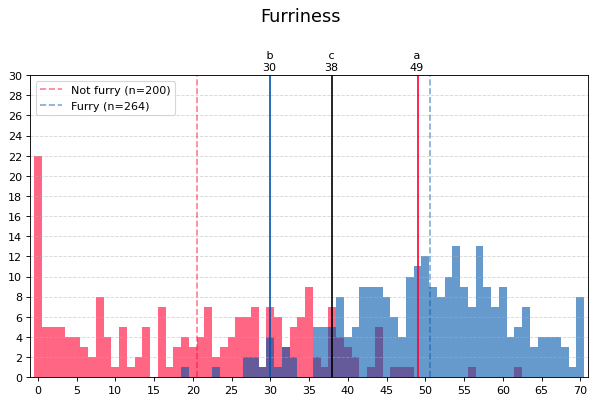

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where((df.iloc[:, 0] >= 3) | (df.iloc[:, 1] >= 6))]['Furriness'] if i else\
           df.loc[np.where((df.iloc[:, 0] <= 1) | (df.iloc[:, 1] <= 4))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Furry', 'Not furry'), loc='upper left')
ax.legend(('Not furry (n={})'.format(n0), 'Furry (n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

17.55 13.88 
 57.29 8.77 
 45.0 40.0 42.0


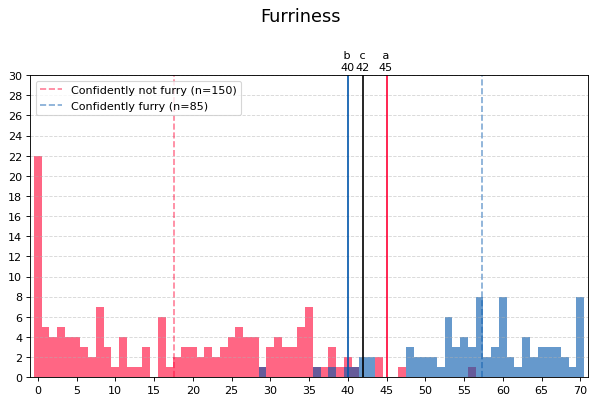

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where((df.iloc[:, 0] == 10*i) | (df.iloc[:, 1] == 10*i))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Confidently not furry (n={})'.format(n0), 'Confidently furry (n={})'.format(n1)), loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

28.47 17.48 
 51.01 11.69 
 63.0 28.0 42.0


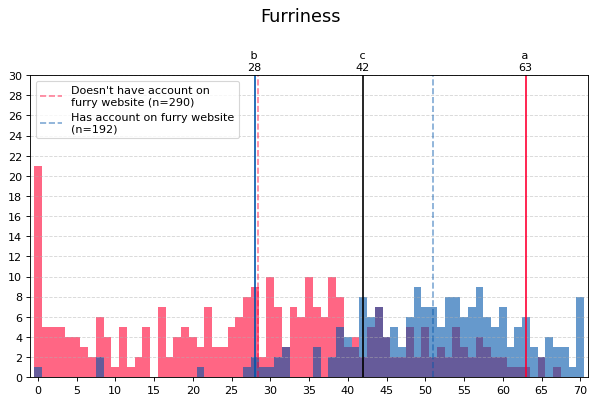

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where(df['Has account furry website'] == i)]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Doesn\'t have account on\nfurry website (n={})'.format(n0), 'Has account on furry website\n(n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

23.88 15.49 
 51.24 10.25 
 55.0 31.0 40.0


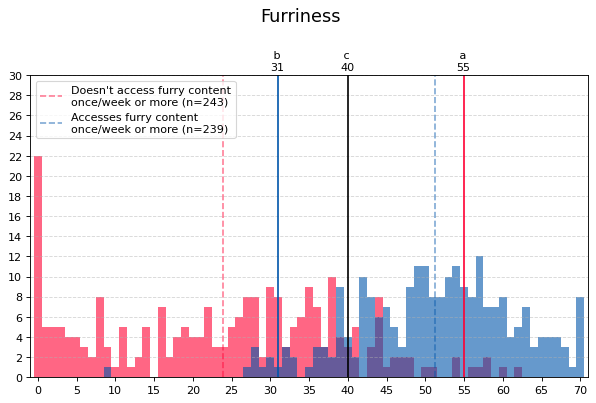

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where(i == (df.iloc[:, 19:30] >= 2).any(axis=1))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Doesn\'t access furry content\nonce/week or more (n={})'.format(n0), 'Accesses furry content\nonce/week or more (n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

27.49 17.61 
 50.79 10.77 
 63.0 29.0 42.0


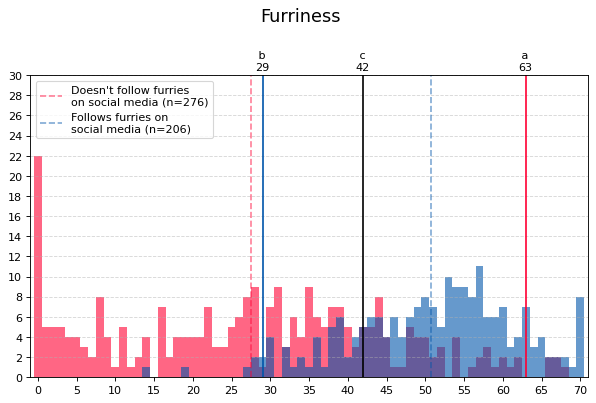

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where(i == df.iloc[:, [16,17]].any(axis=1))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Doesn\'t follow furries\non social media (n={})'.format(n0), 'Follows furries on\nsocial media (n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

30.34 19.01 
 44.61 16.02 
 68.0 13.0 38.0


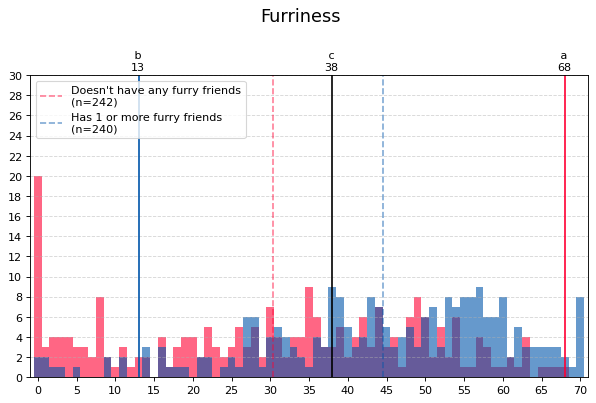

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where(i == (df.iloc[:, 30] >= 1))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Doesn\'t have any furry friends\n(n={})'.format(n0), 'Has 1 or more furry friends\n(n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

22.52 14.83 
 50.95 10.15 
 52.0 31.0 39.0


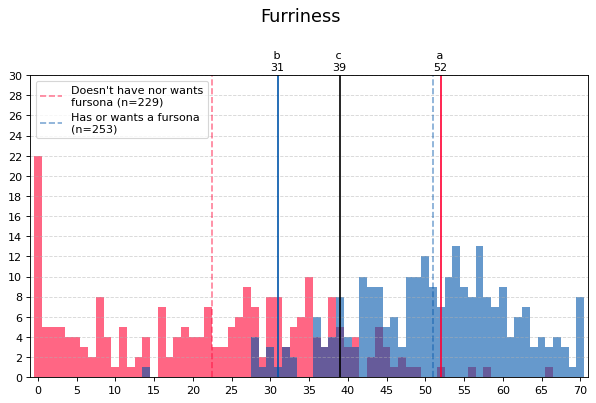

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where(i == (df.iloc[:, 33] >= 1))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Doesn\'t have nor wants\nfursona (n={})'.format(n0), 'Has or wants a fursona\n(n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

26.33 15.76 
 53.12 9.88 
 58.0 33.0 43.0


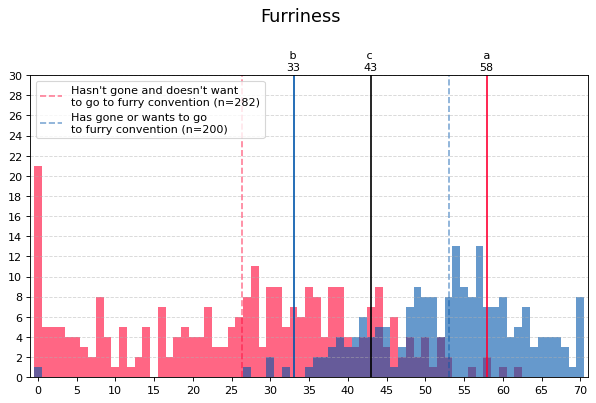

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where(i == (df.iloc[:, 31] >= 1))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Hasn\'t gone and doesn\'t want\nto go to furry convention (n={})'.format(n0), 'Has gone or wants to go\nto furry convention (n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

29.19 16.89 
 54.07 9.84 
 63.0 34.0 45.0


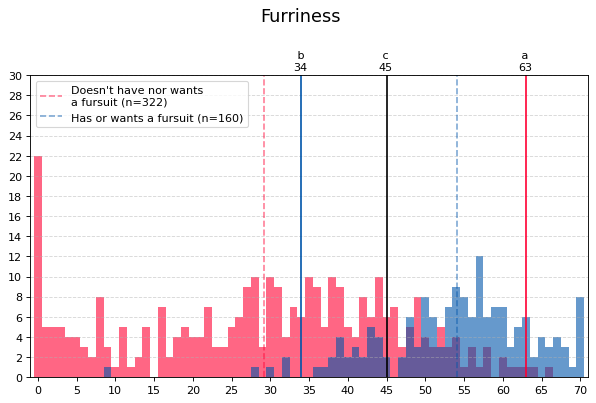

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
n0, n1 = None, None

for i in range(2):
    color = ('#f03', '#05a')[i]
    data = df.loc[np.where(i == (df.iloc[:, 32] >= 1))]['Furriness']
    x = np.arange(71)
    y = [len(np.where(data == j)[0]) for j in x]
    mean = data.mean()
    rects = ax.bar(x, y, color=color, width=1, alpha=.6)
    ax.plot([mean]*2, [0, 30], color=color, linestyle='--', alpha=.5)
    if i: m1, s1, n1 = mean, data.std(ddof=0), len(data)
    else: m0, s0, n0 = mean, data.std(ddof=0), len(data)
a = np.round(m0 + s0 * 2)
b = np.round(m1 - s1 * 2)
c = np.round((s0*m1 + s1*m0) / (s0 + s1))
print(m0.round(2), s0.round(2), '\n', m1.round(2), s1.round(2), '\n', a, b, c)
ax.plot([a, a], [0, 30], color='#f03')
ax.plot([b, b], [0, 30], color='#05a')
ax.plot([c, c], [0, 30], color='#000')
ax.text(a-1, 30.5, ' a \n%i' % a, fontsize=10)
ax.text(b-1, 30.5, ' b \n%i' % b, fontsize=10)
ax.text(c-1, 30.5, ' c \n%i' % c, fontsize=10)
ax.set_ylim((0, 30))
ax.set_yticks(range(0, 31, 2))
ax.set_xlim((-1, 71))
ax.set_xticks(range(0, 71, 5))
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.legend(('Doesn\'t have nor wants\na fursuit (n={})'.format(n0), 'Has or wants a fursuit (n={})'.format(n1)),
          loc='upper left')

fig.suptitle('Furriness', fontsize=16, y=1.05)

plt.show()

In [64]:
print('Furry vs. Not furry\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = ((df['Furriness'] >= i) & (df.iloc[:, 0] != 2) & (df.iloc[:, 1] != 5)).sum() # nº that would be classified as positive according to threshold.
    pred_neg = ((df['Furriness'] < i) & (df.iloc[:, 0] != 2) & (df.iloc[:, 1] != 5)).sum() # nº that would be classified as negative according to threshold.
    true_pos = (((df.iloc[:, 0] >= 3) | (df.iloc[:, 1] >= 6)) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = (((df.iloc[:, 0] <= 1) | (df.iloc[:, 1] <= 4)) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = ((df.iloc[:, 0] >= 3) | (df.iloc[:, 1] >= 6)).sum() # Total nº of true positive cases.
    all_neg = ((df.iloc[:, 0] <= 1) | (df.iloc[:, 1] <= 4)).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Furry vs. Not furry

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	89.77		86.5		88.14		89.77		86.5		88.14		88.36
39	87.88		90.0		88.94		92.06		84.91		88.48		88.79
40	84.85		92.0		88.42		93.33		82.14		87.74		87.93
41	83.33		93.5		88.42		94.42		80.95		87.69		87.72
42	81.44		94.5		87.97		95.13		79.41		87.27		87.07
43	78.03		94.5		86.27		94.93		76.52		85.72		85.13
44	74.62		95.0		84.81		95.17		73.93		84.55		83.41
45	71.21		97.5		84.36		97.41		71.96		84.68		82.54


In [65]:
print('Confidently furry vs. Confidently not furry\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = ((df['Furriness'] >= i) & ((df.iloc[:, 0]%10 == 0) | (df.iloc[:, 1]%10 == 0))).sum() # nº that would be classified as positive according to threshold.
    pred_neg = ((df['Furriness'] < i) & ((df.iloc[:, 0]%10 == 0) | (df.iloc[:, 1]%10 == 0))).sum() # nº that would be classified as negative according to threshold.
    true_pos = (((df.iloc[:, 0] == 10) | (df.iloc[:, 1] == 10)) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = (((df.iloc[:, 0] == 0) | (df.iloc[:, 1] == 0)) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = ((df.iloc[:, 0] == 10) | (df.iloc[:, 1] == 10)).sum() # Total nº of true positive cases.
    all_neg = ((df.iloc[:, 0] == 0) | (df.iloc[:, 1] == 0)).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Confidently furry vs. Confidently not furry

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	97.65		92.67		95.16		88.3		98.58		93.44		94.47
39	96.47		94.67		95.57		91.11		97.93		94.52		95.32
40	96.47		95.33		95.9		92.13		97.95		95.04		95.74
41	95.29		96.67		95.98		94.19		97.32		95.75		96.17
42	94.12		97.33		95.73		95.24		96.69		95.96		96.17
43	91.76		97.33		94.55		95.12		95.42		95.27		95.32
44	89.41		97.33		93.37		95.0		94.19		94.6		94.47
45	89.41		98.67		94.04		97.44		94.27		95.85		95.32


In [66]:
print('Has account on furry website\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = (df['Furriness'] >= i).sum() # nº that would be classified as positive according to threshold.
    pred_neg = (df['Furriness'] < i).sum() # nº that would be classified as negative according to threshold.
    true_pos = ((df['Has account furry website'] == 1) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = ((df['Has account furry website'] == 0) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = (df['Has account furry website'] == 1).sum() # Total nº of true positive cases.
    all_neg = (df['Has account furry website'] == 0).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Has account on furry website

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	91.15		67.93		79.54		65.3		92.06		78.68		77.18
39	90.1		71.38		80.74		67.58		91.59		79.59		78.84
40	87.5		74.14		80.82		69.14		89.96		79.55		79.46
41	85.42		75.17		80.29		69.49		88.62		79.05		79.25
42	83.85		76.55		80.2		70.31		87.75		79.03		79.46
43	79.69		77.24		78.46		69.86		85.17		77.52		78.22
44	76.56		78.97		77.76		70.67		83.58		77.12		78.01
45	72.92		81.38		77.15		72.16		81.94		77.05		78.01


In [67]:
print('Accesses furry content 1/week or more\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = (df['Furriness'] >= i).sum() # nº that would be classified as positive according to threshold.
    pred_neg = (df['Furriness'] < i).sum() # nº that would be classified as negative according to threshold.
    true_pos = (((df.iloc[:, 19:30] >= 2).any(axis=1) == 1) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = (((df.iloc[:, 19:30] >= 2).any(axis=1) == 0) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = ((df.iloc[:, 19:30] >= 2).any(axis=1) == 1).sum() # Total nº of true positive cases.
    all_neg = ((df.iloc[:, 19:30] >= 2).any(axis=1) == 0).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Accesses furry content 1/week or more

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	91.21		79.42		85.32		81.34		90.19		85.77		85.27
39	90.38		83.54		86.96		84.38		89.82		87.1		86.93
40	86.61		85.19		85.9		85.19		86.61		85.9		85.89
41	84.94		86.42		85.68		86.02		85.37		85.69		85.68
42	84.1		88.48		86.29		87.77		84.98		86.38		86.31
43	79.92		88.48		84.2		87.21		81.75		84.48		84.23
44	76.57		89.71		83.14		87.98		79.56		83.77		83.2
45	74.06		93.0		83.53		91.24		78.47		84.85		83.61


In [68]:
print('Follows furries on social media\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = (df['Furriness'] >= i).sum() # nº that would be classified as positive according to threshold.
    pred_neg = (df['Furriness'] < i).sum() # nº that would be classified as negative according to threshold.
    true_pos = ((df.iloc[:, 16:18].any(axis=1) == 1) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = ((df.iloc[:, 16:18].any(axis=1) == 0) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = (df.iloc[:, 16:18].any(axis=1) == 1).sum() # Total nº of true positive cases.
    all_neg = (df.iloc[:, 16:18].any(axis=1) == 0).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Follows furries on social media

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	88.83		69.2		79.02		68.28		89.25		78.77		77.59
39	86.41		71.74		79.07		69.53		87.61		78.57		78.01
40	83.5		74.28		78.89		70.78		85.77		78.28		78.22
41	82.52		76.09		79.31		72.03		85.37		78.7		78.84
42	80.58		77.17		78.88		72.49		84.19		78.34		78.63
43	78.16		78.99		78.57		73.52		82.89		78.2		78.63
44	75.24		80.8		78.02		74.52		81.39		77.95		78.42
45	72.33		83.7		78.01		76.8		80.21		78.51		78.84


In [69]:
print('Has one or more furry friends\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = (df['Furriness'] >= i).sum() # nº that would be classified as positive according to threshold.
    pred_neg = (df['Furriness'] < i).sum() # nº that would be classified as negative according to threshold.
    true_pos = ((df.iloc[:, 30] >= 1) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = ((df.iloc[:, 30] == 0) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = (df.iloc[:, 30] >= 1).sum() # Total nº of true positive cases.
    all_neg = (df.iloc[:, 30] == 0).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Has one or more furry friends

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	72.08		60.74		66.41		64.55		68.69		66.62		66.39
39	68.33		61.98		65.16		64.06		66.37		65.22		65.15
40	65.0		64.05		64.52		64.2		64.85		64.53		64.52
41	62.92		64.88		63.9		63.98		63.82		63.9		63.9
42	61.67		66.53		64.1		64.63		63.64		64.13		64.11
43	60.0		69.01		64.5		65.75		63.5		64.63		64.52
44	56.67		70.25		63.46		65.38		62.04		63.71		63.49
45	53.75		73.14		63.45		66.49		61.46		63.98		63.49


In [70]:
print('Has or wants a fursona\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = (df['Furriness'] >= i).sum() # nº that would be classified as positive according to threshold.
    pred_neg = (df['Furriness'] < i).sum() # nº that would be classified as negative according to threshold.
    true_pos = ((df.iloc[:, 33] >= 1) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = ((df.iloc[:, 33] == 0) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = (df.iloc[:, 33] >= 1).sum() # Total nº of true positive cases.
    all_neg = (df.iloc[:, 33] == 0).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Has or wants a fursona

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	90.51		82.97		86.74		85.45		88.79		87.12		86.93
39	88.93		86.46		87.7		87.89		87.61		87.75		87.76
40	85.77		88.65		87.21		89.3		84.94		87.12		87.14
41	84.19		89.96		87.07		90.25		83.74		87.0		86.93
42	83.0		91.7		87.35		91.7		83.0		87.35		87.14
43	79.05		91.7		85.38		91.32		79.85		85.59		85.06
44	75.49		92.58		84.04		91.83		77.37		84.6		83.61
45	71.94		94.76		83.35		93.81		75.35		84.58		82.78


In [71]:
print('Has gone or wants to go to a furry convention\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = (df['Furriness'] >= i).sum() # nº that would be classified as positive according to threshold.
    pred_neg = (df['Furriness'] < i).sum() # nº that would be classified as negative according to threshold.
    true_pos = ((df.iloc[:, 31] >= 1) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = ((df.iloc[:, 31] == 0) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = (df.iloc[:, 31] >= 1).sum() # Total nº of true positive cases.
    all_neg = (df.iloc[:, 31] == 0).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Has gone or wants to go to a furry convention

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	95.0		72.34		83.67		70.9		95.33		83.11		81.74
39	93.5		75.53		84.52		73.05		94.25		83.65		82.99
40	91.5		78.72		85.11		75.31		92.89		84.1		84.02
41	90.0		80.14		85.07		76.27		91.87		84.07		84.23
42	88.0		81.21		84.6		76.86		90.51		83.68		84.02
43	85.0		82.62		83.81		77.63		88.59		83.11		83.61
44	83.0		85.11		84.05		79.81		87.59		83.7		84.23
45	80.5		88.3		84.4		82.99		86.46		84.72		85.06


In [72]:
print('Has or wants a fursuit\n')
print('Cutoff\tSensitivity\tSpecificity\t(Sens+Spec)\tPPV\t\tNPV\t\t(PPV+NPV)\tAccuracy')

for i in range(38, 46):
    pred_pos = (df['Furriness'] >= i).sum() # nº that would be classified as positive according to threshold.
    pred_neg = (df['Furriness'] < i).sum() # nº that would be classified as negative according to threshold.
    true_pos = ((df.iloc[:, 32] >= 1) & (df['Furriness'] >= i)).sum() # nº of correct positive classifications.
    true_neg = ((df.iloc[:, 32] == 0) & (df['Furriness'] < i)).sum() # nº of correct negative classifications.
    all_pos = (df.iloc[:, 32] >= 1).sum() # Total nº of true positive cases.
    all_neg = (df.iloc[:, 32] == 0).sum() # Total nº of true negative cases.
    
    print(i, '\t',
          round(100*true_pos/all_pos, 2), '\t\t',
          round(100*true_neg/all_neg, 2), '\t\t',
          round(50*(true_pos/all_pos+true_neg/all_neg), 2), '\t\t',
          round(100*true_pos/pred_pos, 2), '\t\t',
          round(100*true_neg/pred_neg, 2), '\t\t',
          round(50*(true_pos/pred_pos+true_neg/pred_neg), 2), '\t\t',
          round(100*(true_pos+true_neg)/(all_pos+all_neg), 2), sep='')

Has or wants a fursuit

Cutoff	Sensitivity	Specificity	(Sens+Spec)	PPV		NPV		(PPV+NPV)	Accuracy
38	95.62		64.29		79.96		57.09		96.73		76.91		74.69
39	94.38		67.39		80.88		58.98		96.02		77.5		76.35
40	91.88		70.19		81.03		60.49		94.56		77.53		77.39
41	90.62		71.74		81.18		61.44		93.9		77.67		78.01
42	88.75		72.98		80.87		62.01		92.89		77.45		78.22
43	87.5		75.47		81.48		63.93		92.4		78.16		79.46
44	84.38		77.33		80.85		64.9		90.88		77.89		79.67
45	81.88		80.43		81.15		67.53		89.93		78.73		80.91


In [73]:
# # Participants who don't consider themselves furries despite reaching the 41 threshold on the furriness scale.
# 359, 86
print(len(np.where((df['Furriness'] >= 41) & ((df.iloc[:, 0] <= 2) | (df.iloc[:, 1] <= 5)))[0]), # Participant disagrees with the scale.
      len(np.where((df['Furriness'] >= 41) & ((df.iloc[:, 0] >= 3) | (df.iloc[:, 1] >= 6)))[0])) # Participant agrees with the scale.
np.where((df['Furriness'] >= 41) & ((df.iloc[:, 0] <= 2) | (df.iloc[:, 1] <= 5)))

16 220


(array([ 80,  86, 112, 167, 194, 218, 272, 279, 306, 307, 344, 358, 359,
        424, 436, 448], dtype=int64),)

In [74]:
220 / (16 + 220)

0.9322033898305084

In [75]:
# Participants who consider themselves furries but didn't reach the 41 threshold on the furriness scale.
# 193
print(len(np.where((df['Furriness'] < 41) & ((df.iloc[:, 0] >= 3) | (df.iloc[:, 1] >= 6)))[0]),
      len(np.where((df['Furriness'] < 41) & ((df.iloc[:, 0] <= 2) | (df.iloc[:, 1] <= 5)))[0]))
np.where((df['Furriness'] < 41) & ((df.iloc[:, 0] >= 3) | (df.iloc[:, 1] >= 6)))

44 202


(array([  1,   9,  13,  18,  36,  41,  54,  57,  58,  69, 133, 136, 138,
        166, 169, 171, 172, 175, 187, 193, 196, 199, 200, 201, 202, 210,
        211, 213, 237, 239, 245, 254, 270, 273, 286, 287, 288, 297, 300,
        326, 381, 401, 452, 458], dtype=int64),)

In [76]:
202 / (44 + 202)

0.8211382113821138

In [77]:
# Participants who have an interest in artwork of anthros but don't like most other types of furry content.
np.where((df['Furriness'] < 41) &\
         ((df.iloc[:, 0] >= 3) | (df.iloc[:, 1] >= 6)) &\
         (df.iloc[:, 6] >= 8) &\
         (df.iloc[:, 7:13].sum(axis=1) <= 30))

(array([ 18,  36,  58,  69, 133, 138, 166, 171, 175, 187, 196, 199, 200,
        201, 202, 213, 239, 245, 270, 273, 286, 297, 381, 401, 452],
       dtype=int64),)